# Extended Connectivity Fingerprint-based Chemical Structural Distance Metric

This notebook provides a pipeline of a new Machine Learning-based similarity/distance metric that better characterize the reaction distance (defined by minimum reaction steps required to transform a group of precursors to a target compound). The performance of predicting the number of reaction steps that connects two groups of compounds are shown below. Here, only compounds/reactions from MetaNetX is considered so the predictions are NOT comparable to that of the model trained on synthetic data collected through expanding plausible reaction networks with "transformation rules", which is part of a different project.

## Header and Import

In [1]:
#--------------------------------------------------#
import os 
import sys
import os.path
from sys import platform
from pathlib import Path
#--------------------------------------------------#
if os.name == 'nt' or platform == 'win32':
    print("Running on Windows")
    if 'ptvsd' in sys.modules:
        print("Running in Visual Studio")
        try:
            os.chdir(os.path.dirname(__file__))
            print('CurrentDir: ', os.getcwd())
        except:
            pass
#--------------------------------------------------#
    else:
        print("Running outside Visual Studio")
        try:
            if not 'workbookDir' in globals():
                workbookDir = os.getcwd()
                print('workbookDir: ' + workbookDir)
                os.chdir(workbookDir)
        except:
            pass
#--------------------------------------------------#
from rdkit import Chem
from rdkit.Chem import AllChem
#--------------------------------------------------#
import ast
import copy
import time
import scipy
import random
import pickle
import scipy.io
import warnings
import argparse
import subprocess
import numpy as np
import pandas as pd
from numpy import *
from tqdm import tqdm
from pathlib import Path
from random import shuffle

Running on Windows
Running outside Visual Studio
workbookDir: C:\Users\ZhiqingXu_AMD\Desktop\DM_3.10\MNX-VAE_v3.10


## Step01 Obtain SMILES and DB Entries from MetaNetX compound database

In [2]:
def readlines_chem_prop(file, mark="", skip_header=False):
    count_x=0
    cmpd_mnxid_smiles_dict=dict([])
    # skip lines not containing information
    # There are 388 lines of header (trivial information about the DB)
    if skip_header==True:
        for i in range(388): 
            line = file.readline()

    # Process 10^6 at a time in case there are problematic lines in the data file.
    # It is easy to combine the dictionaries afterwards.
    for i in tqdm(range(100000)): 
        count_x+=1
        line = file.readline()
        if line != "" and line != "\n" :
            cmpd_info_list=line.split("\t")
            #print (cmpd_info_list[0], count_x+1)
            cmpd_mnxid_smiles_dict[cmpd_info_list[0]]=cmpd_info_list[6]
        else:
            return cmpd_mnxid_smiles_dict
    return cmpd_mnxid_smiles_dict

In [3]:
def Step01_main_1(loading_folder, saving_folder):
    # Process 10^6 at a time in case there are problematic lines in the data file.
    # Write the compound info into 7 dictionaries, each info of with up to 10^6 compounds
    # It is easy to combine the dictionaries with a few lines of code.
    file_MNX_cmpd_address = loading_folder / "chem_prop.tsv"
    file_MNX_cmpd=open(file_MNX_cmpd_address)
    cmpd_mnxid_smiles_dict1=readlines_chem_prop(file_MNX_cmpd,"",True)
    cmpd_mnxid_smiles_dict2=readlines_chem_prop(file_MNX_cmpd,"",False)
    cmpd_mnxid_smiles_dict3=readlines_chem_prop(file_MNX_cmpd,"",False)
    cmpd_mnxid_smiles_dict4=readlines_chem_prop(file_MNX_cmpd,"",False)
    cmpd_mnxid_smiles_dict5=readlines_chem_prop(file_MNX_cmpd,"",False)
    cmpd_mnxid_smiles_dict6=readlines_chem_prop(file_MNX_cmpd,"",False)
    cmpd_mnxid_smiles_dict7=readlines_chem_prop(file_MNX_cmpd,"",False)

    pickle_out1=open(saving_folder / "Step01_cmpd_mnxid_smiles_dict1","wb")
    pickle.dump(cmpd_mnxid_smiles_dict1, pickle_out1)
    pickle_out1.close()
    pickle_out1=open(saving_folder / "Step01_cmpd_mnxid_smiles_dict2","wb")
    pickle.dump(cmpd_mnxid_smiles_dict2, pickle_out1)
    pickle_out1.close()
    pickle_out1=open(saving_folder / "Step01_cmpd_mnxid_smiles_dict3","wb")
    pickle.dump(cmpd_mnxid_smiles_dict3, pickle_out1)
    pickle_out1.close()
    pickle_out1=open(saving_folder / "Step01_cmpd_mnxid_smiles_dict4","wb")
    pickle.dump(cmpd_mnxid_smiles_dict4, pickle_out1)
    pickle_out1.close()
    pickle_out1=open(saving_folder / "Step01_cmpd_mnxid_smiles_dict5","wb")
    pickle.dump(cmpd_mnxid_smiles_dict5, pickle_out1)
    pickle_out1.close()
    pickle_out1=open(saving_folder / "Step01_cmpd_mnxid_smiles_dict6","wb")
    pickle.dump(cmpd_mnxid_smiles_dict6, pickle_out1)
    pickle_out1.close()
    pickle_out1=open(saving_folder / "Step01_cmpd_mnxid_smiles_dict7","wb")
    pickle.dump(cmpd_mnxid_smiles_dict7, pickle_out1)
    pickle_out1.close()
    
    return

In [4]:
def Step01_main_2(loading_folder, saving_folder):
    # Open all pickles and retrieve compound/reaction info.
    pickle_in1=open(saving_folder / "Step01_cmpd_mnxid_smiles_dict1","rb")
    cmpd_mnxid_smiles_dict1=pickle.load(pickle_in1)
    pickle_in1.close()
    pickle_in1=open(saving_folder / "Step01_cmpd_mnxid_smiles_dict2","rb")
    cmpd_mnxid_smiles_dict2=pickle.load(pickle_in1)
    pickle_in1.close()
    pickle_in1=open(saving_folder / "Step01_cmpd_mnxid_smiles_dict3","rb")
    cmpd_mnxid_smiles_dict3=pickle.load(pickle_in1)
    pickle_in1.close()
    pickle_in1=open(saving_folder / "Step01_cmpd_mnxid_smiles_dict4","rb")
    cmpd_mnxid_smiles_dict4=pickle.load(pickle_in1)
    pickle_in1.close()
    pickle_in1=open(saving_folder / "Step01_cmpd_mnxid_smiles_dict5","rb")
    cmpd_mnxid_smiles_dict5=pickle.load(pickle_in1)
    pickle_in1.close()
    pickle_in1=open(saving_folder / "Step01_cmpd_mnxid_smiles_dict6","rb")
    cmpd_mnxid_smiles_dict6=pickle.load(pickle_in1)
    pickle_in1.close()
    pickle_in1=open(saving_folder / "Step01_cmpd_mnxid_smiles_dict7","rb")
    cmpd_mnxid_smiles_dict7=pickle.load(pickle_in1)
    pickle_in1.close()

    cmpd_mnxid_smiles_dict=cmpd_mnxid_smiles_dict1.copy()
    cmpd_mnxid_smiles_dict.update(cmpd_mnxid_smiles_dict2)
    cmpd_mnxid_smiles_dict.update(cmpd_mnxid_smiles_dict3)
    cmpd_mnxid_smiles_dict.update(cmpd_mnxid_smiles_dict4)
    cmpd_mnxid_smiles_dict.update(cmpd_mnxid_smiles_dict5)
    cmpd_mnxid_smiles_dict.update(cmpd_mnxid_smiles_dict6)
    cmpd_mnxid_smiles_dict.update(cmpd_mnxid_smiles_dict7)

    # Add some keys to the dict to avoid errors
    cmpd_mnxid_smiles_dict["BIOMASS"]=""
    cmpd_mnxid_smiles_dict["MNXM0"]=""
    print ("done merge")

    pickle_out1 = open(saving_folder / "Step01_cmpd_mnxid_smiles_dict_merged","wb")
    pickle.dump(cmpd_mnxid_smiles_dict, pickle_out1)
    pickle_out1.close()
    print("Step01 Done!")
    
    return 

In [5]:
loading_folder = Path("MNX_data/")
saving_folder = Path("MNX_ECFP_savings/")
Step01_main_1(loading_folder, saving_folder)
Step01_main_2(loading_folder, saving_folder)

 94%|██████████████████████████████████████████████████████████████████▉    | 94309/100000 [00:00<00:00, 698426.12it/s]


done merge
Step01 Done!


## Step02 Obtain Reactions and DB Entries from MetaNetX Reaction Database

In [6]:
def retrieve_cmpd_id(extended_mnx_id):
# Remove the useless part of the compounds id strings
# Example: MNXM89588@MNXD1 -> MNXM89588
    if extended_mnx_id.find("@")==-1:
        print ("Unexpected Case", extended_mnx_id) 
        return extended_mnx_id
    return extended_mnx_id.split("@")[0]
#====================================================================================================#
def rxn_str_to_cmpds(one_str):
# Define this function to retrieve reactants/products as well as 
# stoichiometric coefficients from a reaction string.
    coef_list=[]
    cmpds_list=[]
    if one_str.find(" + ") == -1:
        coef_list=[one_str.split(" ")[0]]
        cmpds_list=[retrieve_cmpd_id(one_str.split(" ")[1])]
    else:
        split_temp_list=one_str.split(" + ")
        for one_cmpd in split_temp_list:
            coef_list.append(one_cmpd.split(" ")[0])
            cmpds_list.append(retrieve_cmpd_id(one_cmpd.split(" ")[1]))
    return [coef_list,cmpds_list]
#====================================================================================================#
def readlines_reac_prop(file, mark=""):
    count_x=0
    mnxid_rxn_list=[]
    # skip lines not containing information
    # There are 388 lines of header (trivial information about the DB)

    for i in range(386): 
        line = file.readline()

    for i in tqdm(range(50000)): 
        count_x+=1
        #print (count_x) 
        line = file.readline()

        if line != "" and line != "\n" :
            one_rxn_info_list=line.split("\t")
            rxn_id=one_rxn_info_list[0]
            rctt_str=one_rxn_info_list[1].split(" = ")[0]
            prod_str=one_rxn_info_list[1].split(" = ")[1]
            #print (rxn_str_to_cmpds(rctt_str)+rxn_str_to_cmpds(prod_str))
            mnxid_rxn_list.append(rxn_str_to_cmpds(rctt_str)+rxn_str_to_cmpds(prod_str))

        else:
            return mnxid_rxn_list
    return mnxid_rxn_list

In [7]:
def Step02_main(loading_folder, saving_folder):
    # From MetaNetX Database (reac_prop.tsv), 
    # obtain reaction information (stoichiometric coefficient and MNXid) 
    # for ~40000 reactions and store the data into a python list.
    file_MNX_rxn_address = loading_folder/ "reac_prop.tsv"
    file_MNX_rxn=open(file_MNX_rxn_address)
    mnxid_rxn_list=readlines_reac_prop(file_MNX_rxn,"")

    pickle_out1 = open(saving_folder / "Step02_mnxid_rxn_list","wb")
    pickle.dump(mnxid_rxn_list, pickle_out1)
    pickle_out1.close()
    
    print("Step02 Done!")
    
    return

In [8]:
loading_folder = Path("MNX_data/")
saving_folder = Path("MNX_ECFP_savings/")
Step02_main(loading_folder, saving_folder)

 89%|████████████████████████████████████████████████████████████████▋        | 44320/50000 [00:00<00:00, 96326.20it/s]


Step02 Done!


## Step03 Cleaning Reaction Data

In [9]:
# Step03 Imports
#--------------------------------------------------#
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AtomPairs import Pairs
from rdkit.Chem.AtomPairs import Torsions
from rdkit.Chem.Fingerprints import FingerprintMols
#--------------------------------------------------#
import statistics
#--------------------------------------------------#
from AP_RDKIT_FP import similarity_score
from AP_RDKIT_FP import generate_fingerprint
from AP_RDKIT_FP import similarity_metric_select
#--------------------------------------------------#

running on windows
running outside visual studio
workbookdir: C:\Users\ZhiqingXu_AMD\Desktop\DM_3.10\MNX-VAE_v3.10


In [10]:
def remove_cofactors(one_rxn_info):
    # More cofactor id might be updated later
    cofactor_mnx_id=["MNXM01","MNXM1","MNXM2","MNXM3","MNXM4","MNXM5","MNXM6","MNXM7","MNXM8",\
                    "MNXM9","MNXM10","MNXM11","MNXM12","MNXM13","MNXM14","MNXM15","MNXM15"]
    for one_cofactor in cofactor_mnx_id:
        if one_cofactor in one_rxn_info[1]:
            one_rxn_info[0].remove(one_rxn_info[0][one_rxn_info[1].index(one_cofactor)])
            one_rxn_info[1].remove(one_cofactor)
        if one_cofactor in one_rxn_info[3]:
            one_rxn_info[2].remove(one_rxn_info[2][one_rxn_info[3].index(one_cofactor)])
            one_rxn_info[3].remove(one_cofactor)     
    return one_rxn_info
#====================================================================================================#
def remove_trivial_cmpds(one_rxn_info,cmpd_mnxid_smiles_dict):
    # Remove metal ions, small compounds, NA SMILES strings and empty strings from the list
    # The algorithm here is not perfected, probably need to take into account more conditions
    #print one_rxn_info
    rxn_info=[[],[],[],[]]
    for i in range(len(one_rxn_info[1])):
        one_cmpd=one_rxn_info[1][i]
        cmpd_smiles=cmpd_mnxid_smiles_dict[one_cmpd]
        if len(cmpd_smiles)>7 and cmpd_smiles.find(".")==-1:
            rxn_info[0].append(one_rxn_info[0][i])
            rxn_info[1].append(one_rxn_info[1][i])        

    for i in range(len(one_rxn_info[3])):
        one_cmpd=one_rxn_info[3][i]
        cmpd_smiles=cmpd_mnxid_smiles_dict[one_cmpd]
        if len(cmpd_smiles)>7 and cmpd_smiles.find(".")==-1:
            rxn_info[2].append(one_rxn_info[2][i])
            rxn_info[3].append(one_rxn_info[3][i])        
    #print rxn_info
    return rxn_info

In [11]:
def Step03_main(loading_folder, saving_folder):
    #====================================================================================================#
    #1. Inputs
    pickle_in1=open(saving_folder / "Step01_cmpd_mnxid_smiles_dict_merged","rb")
    cmpd_mnxid_smiles_dict=pickle.load(pickle_in1)
    pickle_in1.close()

    pickle_in1=open(saving_folder / "Step02_mnxid_rxn_list","rb")
    mnxid_rxn_list=pickle.load(pickle_in1)
    pickle_in1.close()
    #====================================================================================================#
    #2. 1st Screening
    screened_mnxid_rxn_list_1=[]
    for one_rxn_info in mnxid_rxn_list:
        one_rxn_info=remove_cofactors(one_rxn_info)
        one_rxn_info=remove_trivial_cmpds(one_rxn_info,cmpd_mnxid_smiles_dict)

        if len(one_rxn_info[0])!=0 and len(one_rxn_info[2])!=0 \
            and len(one_rxn_info[0]) == len(one_rxn_info[1]) \
            and len(one_rxn_info[2]) == len(one_rxn_info[3]):
            screened_mnxid_rxn_list_1.append(one_rxn_info)
    print ("Done 1st Screening")
    del(mnxid_rxn_list)
    mnxid_rxn_list=copy(screened_mnxid_rxn_list_1)
    #====================================================================================================#
    #3. 2nd Screening, get reactions in the form (A -> B) 
    # since we only reconstructs linear pathways here.
    screened_mnxid_rxn_list_2=[]

    parameter_1="ECFP"
    for one_rxn_info in mnxid_rxn_list:
        #print one_rxn_info
        if len(one_rxn_info[1])==1 and len(one_rxn_info[3])==1 \
            and one_rxn_info[1][0]!=one_rxn_info[3][0] \
            and set([one_rxn_info[1][0],one_rxn_info[3][0]]) not in screened_mnxid_rxn_list_2: # Consider simple reactions here (A->B)
            screened_mnxid_rxn_list_2.append(set([one_rxn_info[1][0],one_rxn_info[3][0]]))


    print ("Done 2nd Screening")
    print ("Size of screened MNX reaction list: ", len(screened_mnxid_rxn_list_2))
    #-------------------- (4) --------------------#
    # Get all SMILES needed for further analysis
    # No need to convert all SMILES (through VAE) to latent vectors
    Used_MNXid_set=set([])
    for i in screened_mnxid_rxn_list_2:
        Used_MNXid_set=Used_MNXid_set.union(i)
    #print (Used_MNXid_set)

    Used_SMILES_set=set([])
    for one_mnxid in Used_MNXid_set:
        Used_SMILES_set.add(cmpd_mnxid_smiles_dict[one_mnxid])
    #print (Used_SMILES_set)

    pickle_out1=open(saving_folder / "Step03_screened_mnxid_rxn_list","wb")
    pickle.dump(screened_mnxid_rxn_list_2, pickle_out1)
    pickle_out1.close()

    pickle_out1=open(saving_folder / "Step03_Used_MNXid_set","wb")
    pickle.dump(Used_MNXid_set, pickle_out1)
    pickle_out1.close()

    pickle_out1=open(saving_folder / "Step03_Used_SMILES_set","wb")
    pickle.dump(Used_SMILES_set, pickle_out1)
    pickle_out1.close()
    
    print ("Step03 Done!")
    
    return

In [12]:
loading_folder = Path("MNX_data/")
saving_folder = Path("MNX_ECFP_savings/")
Step03_main(loading_folder, saving_folder)

Done 1st Screening


C:\Anaconda3\envs\rdkit3\lib\site-packages\numpy\lib\function_base.py:804: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)


Done 2nd Screening
Size of screened MNX reaction list:  11057
Step03 Done!


## Step04 Use a Pre-trained (Variational Auto-Encoder) VAE to Obtain VAE-encodings

This Step is not shown here (due to different python env and other excuses). See code in the folder `Step04_VAEConversion`.

Step04 use pretrained VAE from https://github.com/chembl/autoencoder_ipython.

In [13]:
# Check outputs of Step04_VAEConversion.py
#--------------------------------------------------#
saving_folder = Path("MNX_ECFP_savings/")
#--------------------------------------------------#
pickle_in1 = open(saving_folder / "Step04_smiles_VAEVEC_dict","rb")
smiles_VAEVEC_dict = pickle.load(pickle_in1)
pickle_in1.close()
#--------------------------------------------------#
# print size of dict
print("len(smiles_VAEVEC_dict): ", len(smiles_VAEVEC_dict))
#--------------------------------------------------#
# print sample VAE-encodings
print("sample VAE-encodings: ", list(smiles_VAEVEC_dict.keys())[1])
print("dimension of VAE-encodings: ", len(list(smiles_VAEVEC_dict.values())[1]))
#print(list(smiles_VAEVEC_dict.values())[0])


len(smiles_VAEVEC_dict):  8689
sample VAE-encodings:  O[C@@H]1CC\C(=C\C(=O)C([O-])=O)[C@H]2O[C@@H]12
dimension of VAE-encodings:  292


## Step05 Visualize the Screened Reaction/Pathway Network
Write a json file for Step05_index.html, which shows the reaction network where pathways will be extracted from in the next step. 

Use `chrome --allow-file-access-from-files` to view the html file. 

In [14]:
def Step05_main(loading_folder, saving_folder):
    #====================================================================================================#
    # 1. Open all pickles required.
    pickle_in1=open(saving_folder / "Step03_screened_mnxid_rxn_list","rb")
    screened_mnxid_rxn_list=pickle.load(pickle_in1)
    pickle_in1.close()

    pickle_in1=open(saving_folder / "Step03_Used_SMILES_set","rb")
    Used_SMILES_set=pickle.load(pickle_in1)
    pickle_in1.close()
    
    #====================================================================================================#
    # 2. Format the data into two sets, nodes_set and edges_set
    count_x=0
    nodes_set=set([])
    edges_list=[]
    for i in screened_mnxid_rxn_list:
        count_x+=1
        # The plot cannot include all 10000 reactions (plot 1/10 to make it not too messy)
        if count_x>2000:
            break
        nodes_set=nodes_set.union(i)
        edges_list.append([set([list(i)[0]]),set([list(i)[1]])])

    nodes_list=list(nodes_set)

    #====================================================================================================#
    # 3. Write a json file based on the formated data for making the graph in D3.js
    text_file = open(saving_folder / "Step05_graph.json", "w")
    text_file.write("{")
    text_file.write("\n")
    text_file.write("  \"nodes\": [")
    text_file.write("\n")

    for i in nodes_list:
        if nodes_list.index(i) == len(nodes_list)-1:
            text_file.write("    {\"id\": \""+i+"\", \"group\": "+ "0" +"}" )
        else:
            text_file.write("    {\"id\": \""+i+"\", \"group\": "+ "0" +"}," )
        text_file.write("\n")
    text_file.write("  ],")
    text_file.write("\n")
    text_file.write("  \"links\": [")
    text_file.write("\n")

    for i in edges_list:
        str1="\"source\": [ \""
        for j in i[1]: # source
            str1=str1+j+"\", \""
        str1=str1[0:-3]+" ]"

        str2="\"target\": [ \""
        for j in i[0]: # target
            str2=str2+j+"\", \""
        str2=str2[0:-3]+" ]"

        str3="\"value\": 0"
        if edges_list.index(i)==len(edges_list)-1:
            text_file.write("    {" + str1 + "," + str2 + "," + str3 + "}")
        else:
            text_file.write("    {" + str1 + "," + str2 + "," + str3 + "},")
        text_file.write("\n")

    text_file.write("  ]")
    text_file.write("\n")
    text_file.write("}")
    text_file.write("\n")

    print ("Step05 Done!")

In [15]:
loading_folder = Path("MNX_data/")
saving_folder = Path("MNX_ECFP_savings/")
Step05_main(loading_folder, saving_folder)

from IPython.display import IFrame
saving_folder_dir = "MNX_ECFP_savings"
#IFrame(src = saving_folder_dir + "/Step05_index.html", width=700, height=600)

Step05 Done!


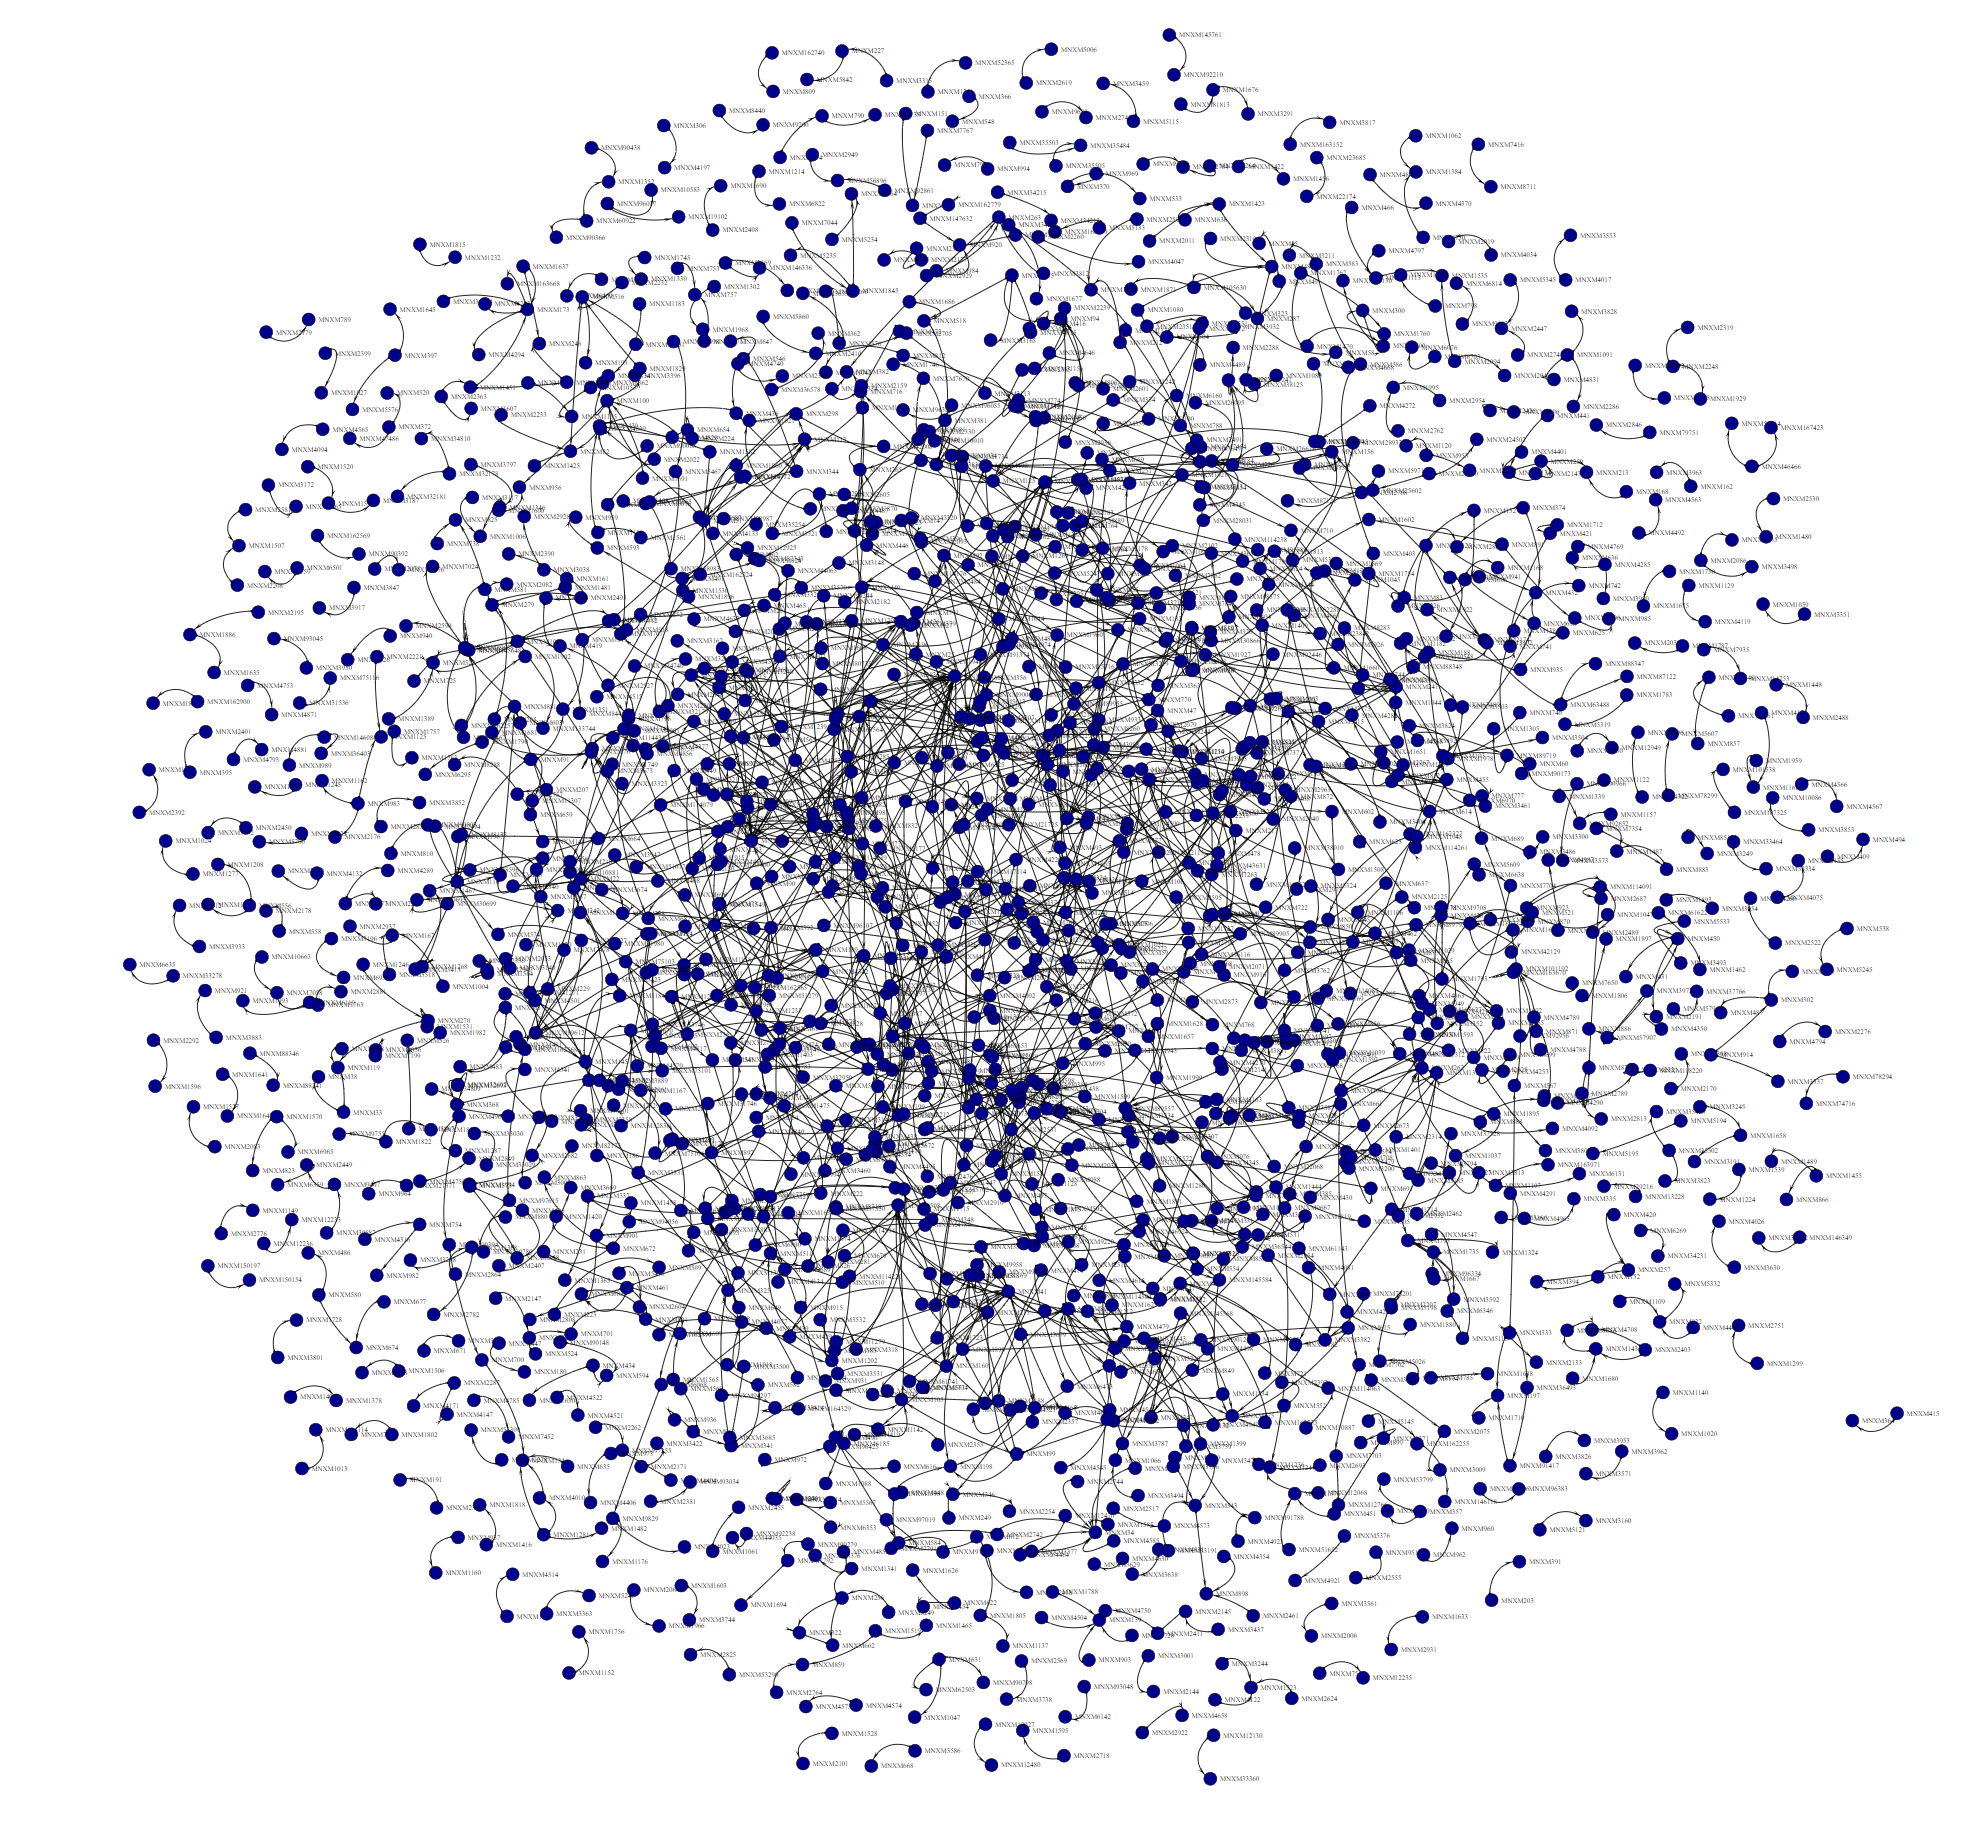

In [16]:
from IPython.display import Image
Image(saving_folder / 'Step05_graph.png')

## Step 06 Reaction Network Construction

Although already visualized, reaction network needs to be constructed in the program to get ready for extracting pathways from reaction network

In [17]:
def expand_rxn_tree(one_MNXid, RXN_Network_N_step_dict, RXN_dict, max_len=10 ):
    # A brute-force algorithm is used here (INEFFICIENT). 
    # Computation does not take long for this easy problem
    # Efficient graph search algorithm can be used here if constructing a large network

    #print(one_MNXid)
    RXN_tree_N_step=[[] for i in range(max_len)]
    for i in range(max_len):
        if i==0:
            RXN_tree_N_step[i]=list(set(RXN_dict[one_MNXid]))
        else:
            cmpds_tb_expanded=RXN_tree_N_step[i-1]
            next_lv_cmpds=[]
            duplicates=set([one_MNXid,])
            for j in range(i):
                k=i-j-1
                duplicates=duplicates.union(set(RXN_tree_N_step[k]))
            for one_cmpd in cmpds_tb_expanded:
                next_lv_cmpds=[item for item in set(RXN_dict[one_cmpd]) if item not in duplicates]
            RXN_tree_N_step[i]=next_lv_cmpds
    #print(RXN_tree_N_step)
    RXN_Network_N_step_dict[one_MNXid]=RXN_tree_N_step
    return


In [18]:
def Step06_main(loading_folder, saving_folder):
    #====================================================================================================#
    # 1. Open all pickles and retrieve compound/reaction info.
    pickle_in1=open(saving_folder / "Step03_screened_mnxid_rxn_list","rb")
    screened_mnxid_rxn_list=pickle.load(pickle_in1)
    pickle_in1.close()
    pickle_in1=open(saving_folder / "Step03_Used_MNXid_set","rb")
    Used_MNXid_set=pickle.load(pickle_in1)
    pickle_in1.close()

    #====================================================================================================#
    # 2. Format the reactions into a dictionary, 
    # Values are a list of MNXid's that are linked to the key with one step reaction
    RXN_dict=dict([])
    for one_MNXid in Used_MNXid_set:
        prod_list=[]
        for one_pair in screened_mnxid_rxn_list:
            if one_MNXid in one_pair:
                temp_pair=list(one_pair)
                temp_pair.remove(one_MNXid)
                prod_list.append(temp_pair[0])
        RXN_dict[one_MNXid]=prod_list

    #====================================================================================================#
    RXN_Network_N_step_dict=dict([])
    print("len(Used_MNXid_set): ", len(Used_MNXid_set))
    for one_MNXid in tqdm(Used_MNXid_set):
        expand_rxn_tree(one_MNXid, RXN_Network_N_step_dict, RXN_dict)

    pickle_out1=open(saving_folder / "Step06_RXN_Network_N_step_dict","wb")
    pickle.dump(RXN_Network_N_step_dict, pickle_out1)
    pickle_out1.close()

    print ("Step06 done!")

    return

In [19]:
loading_folder = Path("MNX_data/")
saving_folder = Path("MNX_ECFP_savings/")

Step06_main(loading_folder, saving_folder)

len(Used_MNXid_set):  10429


100%|█████████████████████████████████████████████████████████████████████████| 10429/10429 [00:00<00:00, 22137.22it/s]


Step06 done!


## Step07 Extract Reaction Distances Data from the Pathway Network

In [20]:
# Step07 Imports
#--------------------------------------------------#
from scipy import stats
#--------------------------------------------------#
import pylab as pl
import seaborn as sns
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
#--------------------------------------------------#

In [21]:
def update_paired_cmpds_list(distance, paired_cmpds_set, paired_cmpds_list, all_pairs_list):
    # Step07_paired_cmpds_list  : [ [paired_cmpds_set, distance], [ set([frozenset(), frozenset()]) , d ], 
    #                               [ set([fs(), fs()]) , d ], 
    #                               [ set([ fs , fs ]) , d ], ..., [], [] , ... ]
    # Step07_all_pairs_list     : [ paired_cmpds_set, 
    #                               set( [  frozenset( cmpd_x, ), frozenset(cmpd_x, cmpd_x, cmpd_x, ...)  ] ), 
    #                               set( [fs(), fs()] ), 
    #                               set( [ fs , fs ] ), ..., set([]), ...  ]
    
    # Used in parse_one_pathway(one_pathway, paired_cmpds_list, all_pairs_list)
    if paired_cmpds_set not in all_pairs_list:
        all_pairs_list.append(paired_cmpds_set)
        paired_cmpds_list.append([paired_cmpds_set,distance])
    else: 
        for i in range(len(paired_cmpds_list)):
            if paired_cmpds_list[i][0]==paired_cmpds_set and paired_cmpds_list[i][1]>distance: # means we have a update in distance 
                #print ("update for shorter distance found")
                paired_cmpds_list[i][1]=distance
    return

In [22]:
def Step07_main(loading_folder, saving_folder): # Time-consuming
    #====================================================================================================#
    # Open the Step01 temp file and retrieve useful info.
    pickle_in1=open(saving_folder / "Step01_cmpd_mnxid_smiles_dict_merged","rb")
    cmpd_mnxid_smiles_dict=pickle.load(pickle_in1)
    pickle_in1.close()
    
    #====================================================================================================#
    # Open the Step06 temp file and retrieve useful info.
    pickle_in1=open(saving_folder / "Step06_RXN_Network_N_step_dict","rb")
    RXN_Network_N_step_dict=pickle.load(pickle_in1)
    pickle_in1.close()

    #====================================================================================================#
    # Again, use brute-force here since it wont take too long for this amount of data
    print ("Start working on Cmpd Pairs & Distance", len(RXN_Network_N_step_dict))
    len_pwy = len(list(RXN_Network_N_step_dict.values())[0])
    print ("len_pwy (steps of expansion): ", len_pwy) # steps of expansion

    #====================================================================================================#
    paired_cmpds_list=[]
    all_pairs_list=[]
    for one_cmpd in tqdm(RXN_Network_N_step_dict.keys()):

        for i in range(len_pwy):
            for another_cmpd in RXN_Network_N_step_dict[one_cmpd][i]:
                distance = i+1
                paired_cmpds=[(cmpd_mnxid_smiles_dict[one_cmpd],),(cmpd_mnxid_smiles_dict[another_cmpd],)]
                paired_cmpds_set=set(frozenset(i) for i in paired_cmpds) # set?????
                update_paired_cmpds_list(distance, paired_cmpds_set, paired_cmpds_list, all_pairs_list)

    save_pickle_paired_cmpds_list = saving_folder / "Step07_paired_cmpds_list"
    save_pickle_all_pairs_list = saving_folder / "Step07_all_pairs_list"
    
    pickle_out1=open(save_pickle_paired_cmpds_list,"wb")
    pickle.dump(paired_cmpds_list, pickle_out1)
    pickle_out1.close()

    pickle_out2=open(save_pickle_all_pairs_list,"wb")
    pickle.dump(all_pairs_list, pickle_out2)
    pickle_out2.close()

    print ("Step07 Done!")

    return

In [23]:
loading_folder = Path("MNX_data/")
saving_folder = Path("MNX_ECFP_savings/")
#Step07_main(loading_folder, saving_folder)

## Step08 Obtain ECFPs of compounds using CDK library

In [24]:
# Step08 Imports
#--------------------------------------------------#
import seaborn as sns
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
#--------------------------------------------------#
from scipy import stats
from matplotlib import pylab as pl
#--------------------------------------------------#
from AP_RDKIT_FP import *
from Step07_NetworkToDistance import *
#--------------------------------------------------#

Running on Windows
Running outside Visual Studio
workbookDir: C:\Users\ZhiqingXu_AMD\Desktop\DM_3.10\MNX-VAE_v3.10


In [25]:
def Step08_open_Step07_pickles(Step07_paired_cmpds_list_file_address, Step07_all_pairs_list_file_address):
    # Step07_paired_cmpds_list  : [ [paired_cmpds_set, distance], [ set([frozenset(), frozenset()]) , d ], 
    #                               [ set([fs(), fs()]) , d ], 
    #                               [ set([ fs , fs ]) , d ], ..., [], [] , ... ]
    # Step07_all_pairs_list     : [ paired_cmpds_set, 
    #                               set( [  frozenset( cmpd_x, ), frozenset(cmpd_x, cmpd_x, cmpd_x, ...)  ] ), 
    #                               set( [fs(), fs()] ), 
    #                               set( [ fs , fs ] ), ..., set([]), ...  ]
 
    print ("loading data!")
    pickle_in1=open(Step07_paired_cmpds_list_file_address,"rb")
    paired_smiles_list=pickle.load(pickle_in1)
    pickle_in1.close()

    pickle_in2=open(Step07_all_pairs_list_file_address,"rb")
    all_pairs_list=pickle.load(pickle_in2)
    pickle_in2.close()
    print ("pickle data loaded!")

    return paired_smiles_list, all_pairs_list

In [26]:
def get_all_smiles_from_all_pairs_list(all_pairs_list):
    # all_pairs_list     : [ paired_cmpds_set, 
    #                        set( [  frozenset( cmpd_x, ), frozenset(cmpd_x, cmpd_x, cmpd_x, ...)  ] ), 
    #                        set( [fs(), fs()] ), 
    #                        set( [ fs , fs ] ), ..., set([]), ...  ]

    all_smiles=[]
    for one_pair_set in all_pairs_list:
        for one_frozen_set in one_pair_set:
            for one_cmpd_x in one_frozen_set:
                if one_cmpd_x not in all_smiles:
                    all_smiles.append(one_cmpd_x)
    return all_smiles

In [27]:
def Initialize_all_smiles_all_ecfps(loading_folder, saving_folder, ECFP_encodings):

    #====================================================================================================#
    Step07_paired_cmpds_list_file_address = saving_folder  / "Step07_paired_cmpds_list" # "_0" files are old files
    Step07_all_pairs_list_file_address = saving_folder / "Step07_all_pairs_list" # "_0" files are old files
    paired_smiles_list, all_pairs_list = Step08_open_Step07_pickles(Step07_paired_cmpds_list_file_address, Step07_all_pairs_list_file_address)
    
    all_smiles = get_all_smiles_from_all_pairs_list(all_pairs_list)
    print ("number of SMILES(compounds): ", len(all_smiles))
    print ("number of SMILES pairs (compound pairs w/ distance info): ", len(all_pairs_list))
    (all_ecfps, all_smiles_ecfps_dict) = generate_all_smiles_ecfps_list_dict(all_smiles, 
                                                                             ecfp_type = ECFP_encodings, 
                                                                             iteration_number = round(int(ECFP_encodings[-1])/2.) )

    #====================================================================================================#
    pickle_out1=open(saving_folder  / ("Step08_all_cmpds_" + ECFP_encodings),"wb")
    pickle.dump(all_smiles, pickle_out1)
    pickle_out1.close()
    pickle_out2=open(saving_folder  / ("Step08_all_ecfps_" + ECFP_encodings),"wb")
    pickle.dump(all_ecfps, pickle_out2)
    pickle_out2.close()
    pickle_out3=open(saving_folder  / ("Step08_all_cmpds_ecfps_dict_" + ECFP_encodings),"wb")
    pickle.dump(all_smiles_ecfps_dict, pickle_out3)
    pickle_out3.close()

    print ("Done Initialize_all_smiles_all_ecfps! ")
    
def Step08_main(loading_folder, saving_folder, ECFP_encodings):
    Initialize_all_smiles_all_ecfps(loading_folder, saving_folder, ECFP_encodings)
    print("Step08 Done!")
    return

In [28]:
loading_folder = Path("MNX_data/")
saving_folder = Path("MNX_ECFP_savings/")
# Args
# Select ECFP encodings
#-------------------      0        1        2        3          4         5        6     
ECFP_encodings_list = ["ECFP2", "ECFP4", "ECFP6", "JTVAE", "MorganFP", "ECFP8", "ECFPX"]
ECFP_encodings = ECFP_encodings_list[0]
ECFP_type = ECFP_encodings[-1] if ECFP_encodings in ["ECFP2", "ECFP4", "ECFP6"] else "6" # 2, 4, 6

#Step08_main(loading_folder, saving_folder, ECFP_encodings)

## Step09 Get Processed Dataset Ready for Machine Learning Model(s)
X - Difference between count encodings of each pair of compounds
y - reaction distance (defined by number of minimum reaction steps required to transform a set of precursor to a target)
In this example, we only consider pairs of compounds. Reaction distances of pairs of precursors and target trained on chemically plausible synthetic pathway network have been used to train a separate model and the model has been shown to have stronger predictive performance.

In [29]:
# Step09 Imports
#--------------------------------------------------#
import seaborn as sns
import matplotlib as mpl
import matplotlib.pylab as pl
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
#--------------------------------------------------#
from scipy import stats
#--------------------------------------------------#
from AP_RDKIT_FP import *
from Step07_NetworkToDistance import *
#--------------------------------------------------#
from sklearn.manifold import TSNE

In [30]:
def list_smiles_to_ecfp_through_dict(smiles_list, all_cmpds_ecfps_dict):
    ecfp_list=[]
    for one_smiles in smiles_list:
        ecfp_list=ecfp_list+all_cmpds_ecfps_dict[one_smiles]
    return ecfp_list

#====================================================================================================#
def parse_one_pair_info(one_pair_info, all_ecfps, all_cmpds_ecfps_dict):
    dimension=len(all_ecfps)
    X1i=[0]*dimension
    X2i=[0]*dimension
    X1i_ecfp_list=list_smiles_to_ecfp_through_dict(list(list(one_pair_info[0])[0]),all_cmpds_ecfps_dict)
    X2i_ecfp_list=list_smiles_to_ecfp_through_dict(list(list(one_pair_info[0])[1]),all_cmpds_ecfps_dict)
    distance=one_pair_info[1]
    for one_ecfp in X1i_ecfp_list:
        X1i[all_ecfps.index(one_ecfp)]=X1i_ecfp_list.count(one_ecfp)
    for one_ecfp in X2i_ecfp_list:
        X2i[all_ecfps.index(one_ecfp)]=X2i_ecfp_list.count(one_ecfp)
    Yi=distance
    return (X1i,X2i,Yi)

#====================================================================================================#
def list_subtract(list_a,list_b):
    list_out=[]
    for i in range(len(list_a)):
        list_out.append(list_a[i]-list_b[i])
    return list_out

In [31]:
def Step09_main(loading_folder, saving_folder, ECFP_encodings):
    
    #====================================================================================================#
    pickle_in1=open(saving_folder  / "Step07_paired_cmpds_list","rb")
    paired_smiles_list=pickle.load(pickle_in1)
    pickle_in1.close()
    
    pickle_in2=open(saving_folder  / "Step07_all_pairs_list","rb")
    all_pairs_list=pickle.load(pickle_in2)
    pickle_in2.close()
    #====================================================================================================#
    pickle_in1=open(saving_folder  / ("Step08_all_cmpds_"+ECFP_encodings),"rb")
    all_smiles=pickle.load(pickle_in1)
    pickle_in1.close()
    
    pickle_in2=open(saving_folder  / ("Step08_all_ecfps_"+ECFP_encodings),"rb")
    all_ecfps=pickle.load(pickle_in2)
    pickle_in2.close()
    
    pickle_in3=open(saving_folder  / ("Step08_all_cmpds_ecfps_dict_"+ECFP_encodings),"rb")
    all_smiles_ecfps_dict=pickle.load(pickle_in3)
    pickle_in3.close()
    #====================================================================================================#
    for one_pair_info in paired_smiles_list:
        if len(one_pair_info[0])!=2:
            #print (one_pair_info[0])
            #print ("unexpected error: source and target compound are exactly the same and with non-zero reaction distance.")
            paired_smiles_list.remove(one_pair_info)
    print ("screened!")
    #====================================================================================================#
    all_ecfps=list(all_ecfps)
    X_Diff=[]
    Y_Distance=[]

    for one_pair_info in tqdm(paired_smiles_list):
        (X1i, X2i, Yi)=parse_one_pair_info(one_pair_info,all_ecfps,all_smiles_ecfps_dict)
        X_Diff.append(list_subtract(X1i, X2i))
        Y_Distance.append(Yi)
    Step09_processed_data_dict = {"X_data": X_Diff, "y_data": Y_Distance}
    #====================================================================================================#
    # t-SNE visualization
    # Skipped
    #====================================================================================================#    
    pickle_out1=open(saving_folder / ("Step09_processed_data_"+ ECFP_encodings),"wb")
    pickle.dump(Step09_processed_data_dict, pickle_out1)
    pickle_out1.close()

    print("Step09_main Done!")

    return

In [32]:
loading_folder = Path("MNX_data/")
saving_folder = Path("MNX_ECFP_savings/")
ECFP_encodings_list = ["ECFP2", "ECFP4", "ECFP6", "JTVAE", "MorganFP", "ECFP8", "ECFPX"]
ECFP_encodings = ECFP_encodings_list[0]
ECFP_type = ECFP_encodings[-1] if ECFP_encodings in ["ECFP2", "ECFP4", "ECFP6"] else "6" # 2, 4, 6

#Step09_main(loading_folder, saving_folder, ECFP_encodings)

## Step10.3 Decision-Tree Model trained on Processed Reaction Dataset

In [33]:
# Step10.3 Imports
#--------------------------------------------------#
from sklearn import datasets
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler   
from sklearn.model_selection import train_test_split
#--------------------------------------------------#
from sklearn import svm
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report
#--------------------------------------------------#
from sklearn.manifold import TSNE
#from sklearn.tree import DecisionTreeRegressor
#from sklearn.model_selection import GridSearchCV
#--------------------------------------------------#
import seaborn as sns
import matplotlib as mpl
import matplotlib.pylab as pl
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
#--------------------------------------------------#
from scipy import stats
from pathlib import Path
from copy import deepcopy
from datetime import datetime
from tpot import TPOTRegressor
from ipywidgets import IntProgress
#--------------------------------------------------#
# Random Seeds
seed=42
random.seed(seed)
np.random.seed(seed)
#--------------------------------------------------#

C:\Anaconda3\envs\rdkit3\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


### Step10.3.1 Select Input parameters

In [34]:
# Args
#--------------------------------------------------#
THRESHOLD = 10
# Data related parameters
#-------------------      0        1        2        3          4         5        6     
ECFP_encodings_list = ["ECFP2", "ECFP4", "ECFP6", "JTVAE", "MorganFP", "ECFP8", "ECFPX"]
ECFP_encodings = ECFP_encodings_list[0]
ECFP_type = ECFP_encodings[-1] if ECFP_encodings in ["ECFP2", "ECFP4", "ECFP6"] else "6" # 2, 4, 6
#--------------------------------------------------#
# Data imports
Step_code = "Step10_MNX_ECFP_DT"
data_folder = Path("MNX_ECFP_savings/")
data_file="Step09_processed_data_" + ECFP_encodings
#--------------------------------------------------#
# Prediction parameter settings
model_type_list=["Reg", "Clf"] # Reg for ordinal Regression
model_type=model_type_list[1]
#--------------------------------------------------#
# Results savings
results_folder = Path("MNX_ECFP_savings/" + Step_code +"_results/")
if not os.path.exists(results_folder):
    os.makedirs(results_folder)
output_file_3 = Step_code + "_all_X_y.p"
output_file_header = Step_code + "_result_"

### Step10.3.2 Create Temporary Folder for Saving Results

In [35]:
# Create Temp Folder for Saving Results
print(">>>>> Creating temporary subfolder and clear past empty folders! <<<<<")
now = datetime.now()
#d_t_string = now.strftime("%Y%m%d_%H%M%S")
d_t_string = now.strftime("%m%d-%H%M%S")
#====================================================================================================#
# REMOVE PREVIOUS EMPTY FOLDERS !!!!!
results_folder_contents = os.listdir(results_folder)
for item in results_folder_contents:
    if os.path.isdir(results_folder / item):
        try:
            os.rmdir(results_folder / item)
            print("Remove empty folder " + item + "!")
        except:
            #print("Found Non-empty folder " + item + "!")
            pass
temp_folder_name = Step_code + ECFP_type + "_" + d_t_string + "_" + model_type
results_sub_folder = results_folder / (temp_folder_name +"/")
if not os.path.exists(results_sub_folder):
    os.makedirs(results_sub_folder)
print(">>>>> Temporary subfolder created! <<<<<")

>>>>> Creating temporary subfolder and clear past empty folders! <<<<<
>>>>> Temporary subfolder created! <<<<<


In [36]:
class Tee(object):
    def __init__(self, *files):
        self.files = files
    def write(self, obj):
        for f in self.files:
            f.write(obj)
            f.flush() # If you want the output to be visible immediately
    def flush(self) :
        for f in self.files:
            f.flush()
#--------------------------------------------------#
orig_stdout = sys.stdout
f = open(results_sub_folder / 'print_out.txt', 'w')
#sys.stdout = Tee(sys.stdout, f)
print("="*50)
#--------------------------------------------------#
print("Step_code: ", Step_code)
#--------------------------------------------------#
print("ECFP_encodings: ", ECFP_encodings)
#--------------------------------------------------#
print("model_type: ", model_type)
print("="*50)

Step_code:  Step10_MNX_ECFP_DT
ECFP_encodings:  ECFP2
model_type:  Clf


### Step10.3.3 Import Processed Dataset

In [37]:
# Get Input files
# Get Sequence Embeddings from X03 pickles.
with open( data_folder / data_file, 'rb') as Step09_processed_data:
    processed_data_dict = pickle.load(Step09_processed_data)
X_data = processed_data_dict["X_data"]
y_data = processed_data_dict["y_data"]
#====================================================================================================#
y_data = [i if i<=THRESHOLD-1 else THRESHOLD for i in y_data]
#====================================================================================================#
print("max(y_data): ", max(y_data))
print("min(y_data): ", min(y_data))
num_classes=max(y_data)-min(y_data)+1
print("num_classes: ", num_classes)

max(y_data):  10
min(y_data):  1
num_classes:  10


### Step10.3.4 Use t-distributed stochastic neighbor embedding to Visualize the Dataset

Start tSNE ...


C:\Anaconda3\envs\rdkit3\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Anaconda3\envs\rdkit3\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 26000 samples in 0.073s...
[t-SNE] Computed neighbors for 26000 samples in 39.679s...
[t-SNE] Computed conditional probabilities for sample 1000 / 26000
[t-SNE] Computed conditional probabilities for sample 2000 / 26000
[t-SNE] Computed conditional probabilities for sample 3000 / 26000
[t-SNE] Computed conditional probabilities for sample 4000 / 26000
[t-SNE] Computed conditional probabilities for sample 5000 / 26000
[t-SNE] Computed conditional probabilities for sample 6000 / 26000
[t-SNE] Computed conditional probabilities for sample 7000 / 26000
[t-SNE] Computed conditional probabilities for sample 8000 / 26000
[t-SNE] Computed conditional probabilities for sample 9000 / 26000
[t-SNE] Computed conditional probabilities for sample 10000 / 26000
[t-SNE] Computed conditional probabilities for sample 11000 / 26000
[t-SNE] Computed conditional probabilities for sample 12000 / 26000
[t-SNE] Computed conditional probabilities for sa

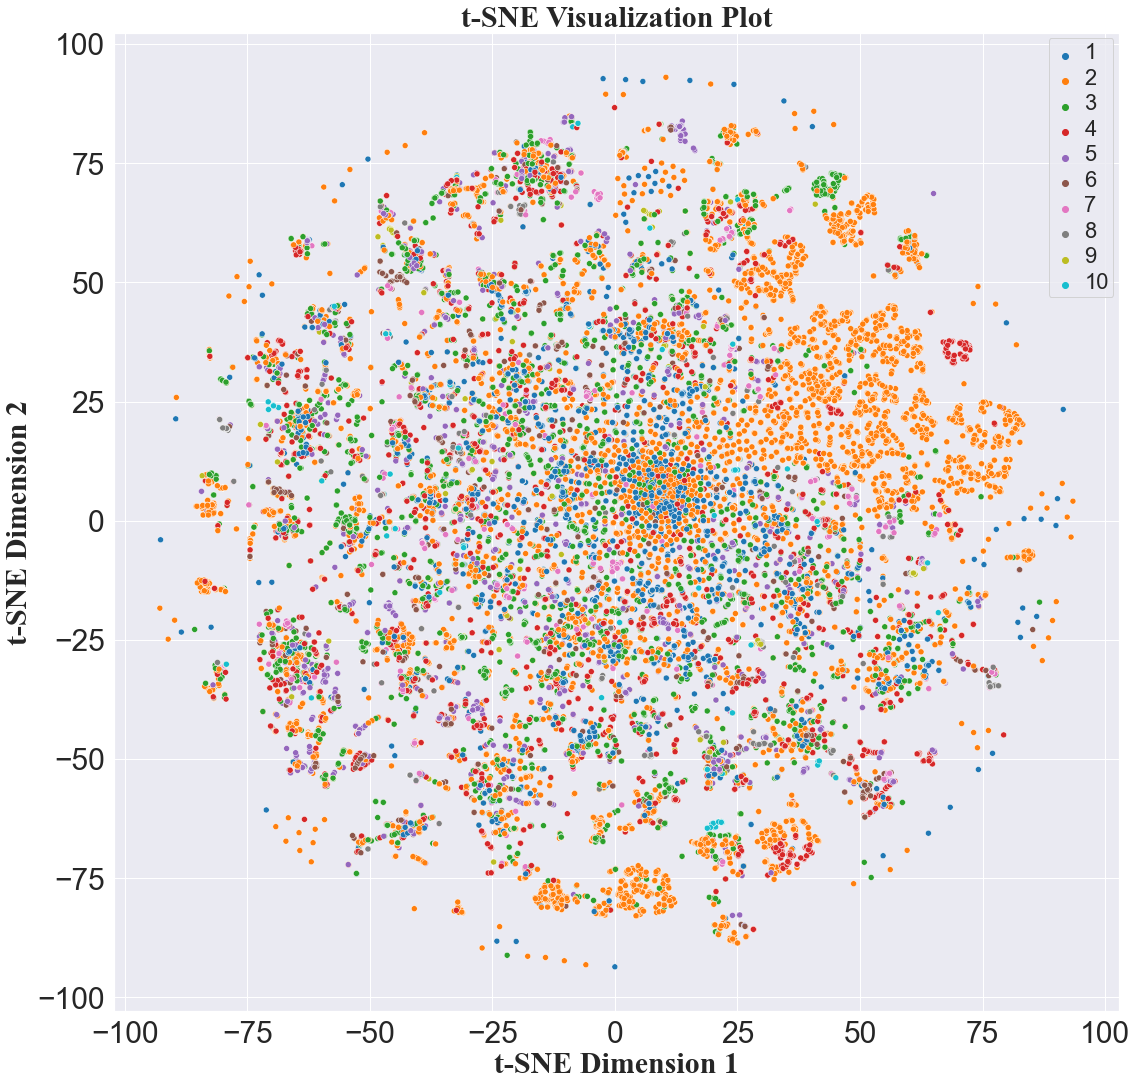

In [38]:
def tSNE_Visualization(X_data, y_data, num_classes):
    print ("Start tSNE ...")
    tsne = TSNE(n_components=2, verbose=1, random_state=42)
    X = tsne.fit_transform(X_data)
    df = pd.DataFrame()
    df["y"] = y_data
    df["tSNE_1"] = X[:,0]
    df["tSNE_2"] = X[:,1]
    print ("End tSNE.")
    #--------------------------------------------------#
    sns.set(style = "darkgrid")
    fig = plt.figure(figsize=(18,18))
    ax = sns.scatterplot(x = "tSNE_1", 
                         y = "tSNE_2", 
                         hue = df.y.tolist(),
                         palette = sns.color_palette("tab10", n_colors=num_classes),
                         #palette = sns.color_palette("hls", num_classes),
                         data=df
                         )
    #--------------------------------------------------#
    font = {'family' : "Times New Roman", 'weight' : 'bold', 'size': 30}
    plt.rc('font', **font)
    plt.rc('font', size=30)          # controls default text sizes
    plt.rc('axes', titlesize=30)     # fontsize of the axes title
    plt.rc('axes', labelsize=30)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=30)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=30)    # fontsize of the tick labels
    plt.rc('legend', fontsize=30)    # legend fontsize
    plt.rc('figure', titlesize=30)   # fontsize of the figure title
    plt.xticks(fontsize = 30)
    plt.yticks(fontsize = 30)
    plt.xlabel('t-SNE Dimension 1',**font)
    plt.ylabel('t-SNE Dimension 2',**font)
    plt.title('t-SNE Visualization Plot',**font)
    plt.setp(ax.get_legend().get_texts(), fontsize='22') # for legend text
    plt.setp(ax.get_legend().get_title(), fontsize='32') # for legend title
    #--------------------------------------------------#
    plt.show()
    fig.savefig(results_sub_folder / (output_file_header + ".04_t-SNE_plot_" +str(len(X_data))+".png") , dpi=500 ) 
    mpl.rcParams.update(mpl.rcParamsDefault)
    return

tSNE_Visualization(X_data[:26000], y_data[:26000], num_classes)

### Step10.3.5 t-SNE 3D plot

Start tSNE ...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1800 samples in 0.005s...


C:\Anaconda3\envs\rdkit3\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Anaconda3\envs\rdkit3\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 1800 samples in 0.254s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1800
[t-SNE] Computed conditional probabilities for sample 1800 / 1800
[t-SNE] Mean sigma: 2.240295
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.932739
[t-SNE] KL divergence after 1000 iterations: 1.402912
End tSNE.


C:\Anaconda3\envs\rdkit3\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


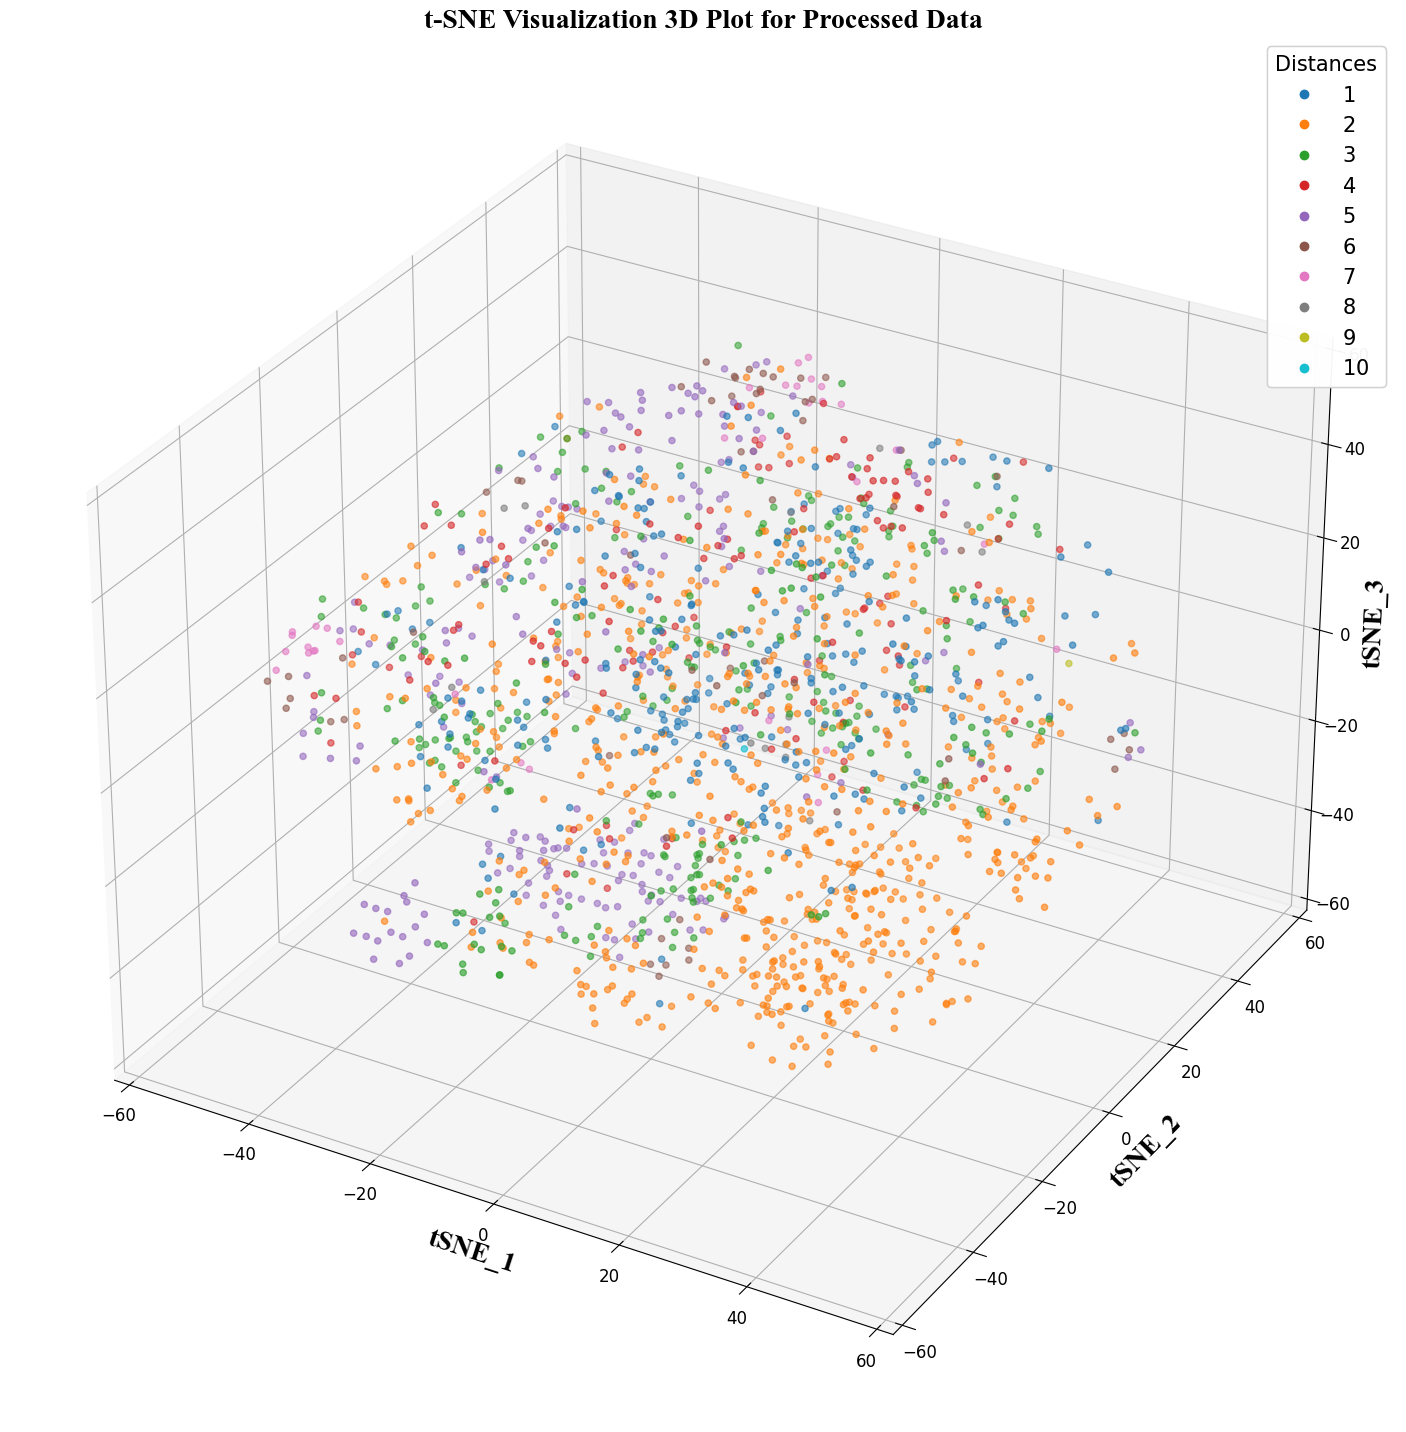

In [39]:
def tSNE_Visualization_3D(X_data, y_data, num_classes):
    print ("Start tSNE ...")
    tsne = TSNE(n_components=3, verbose=1, random_state=0)
    X = tsne.fit_transform(X_data)
    df = pd.DataFrame()
    df["y"] = y_data
    df["tSNE_1"] = X[:,0]
    df["tSNE_2"] = X[:,1]
    df["tSNE_3"] = X[:,2]
    print ("End tSNE.")
    labels_dict = dict([])
    for i in range(num_classes):
        labels_dict[i+1] = "d="+str(i+1)
    #--------------------------------------------------#
    font1 = {'family' : "Times New Roman", 'weight' : 'bold', 'size': 20}
    #--------------------------------------------------#
    ax = plt.figure(figsize=(18,18)).gca(projection='3d')
    sc = ax.scatter(
                    xs=df["tSNE_1"], 
                    ys=df["tSNE_2"], 
                    zs=df["tSNE_3"], 
                    c=df["y"], 
                    #palette=sns.color_palette("hls", num_classes),
                    cmap='tab10',
                    label = df["y"]
                    )
    lg = ax.legend(*sc.legend_elements(),
                    loc="best", 
                    title="Distances",
                    fontsize=15
                    )
    lg.get_title().set_fontsize('15') 
    ax.add_artist(lg)
    #--------------------------------------------------#
    ax.set_xlabel('tSNE_1', **font1)
    ax.set_ylabel('tSNE_2', **font1)
    ax.set_zlabel('tSNE_3', **font1)
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)
    ax.tick_params(axis="z", labelsize=12)
    #--------------------------------------------------#
    ax.set_xlim(-60,60)
    ax.set_ylim(-60,60)
    ax.set_zlim(-60,60)
    #--------------------------------------------------#
    plt.title('t-SNE Visualization 3D Plot for Processed Data', **font1)
    #--------------------------------------------------#
    fig = plt.gcf()
    fig.savefig(results_sub_folder / (output_file_header + ".05_t-SNE_plot3D_" +str(len(X_data))+".png") , dpi=500 ) 
    plt.show()
    mpl.rcParams.update(mpl.rcParamsDefault)
    return

tSNE_Visualization_3D(X_data[:1800], y_data[:1800], num_classes)

### 10.3.6 Create Labels Dictionary

In [40]:
# Define a dict since classes read by pytorch shall be {0,1,...C-1}
class2idx = dict([])
for i in range(10):
    class2idx[i+1]=i
idx2class = {v: k for k, v in class2idx.items()}
y_data = [class2idx[one_class] for one_class in y_data]

#print(y_data)

### 10.3.7 Data Split

In [41]:
# Data Split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.1, stratify=y_data, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

print("data set size: ", len(y_data))
print("train set size: ", len(y_train))
print("valid set size: ", len(y_valid))
print("test set size: ", len(y_test))
print("X dimendion: ", len(X_data[0]))
print("="*50)


data set size:  109081
train set size:  98172
valid set size:  5454
test set size:  5455
X dimendion:  3782


In [42]:
## Normalize Inputs ? NO NEED TO NORMALIZE FOR DECISION TREE!!
#print("Normalizing Inputs... NOT necessary in this case.")
#scaler = MinMaxScaler()
#X_train = scaler.fit_transform(X_train)
#X_valid = scaler.transform(X_valid)
#X_test = scaler.transform(X_test)
#print("Normalized Inputs... NOT necessary in this case.")

X_train, y_train = np.array(X_train), np.array(y_train)
X_valid, y_valid = np.array(X_valid), np.array(y_valid)
X_test , y_test  = np.array(X_test) , np.array(y_test)


### 10.3.8 Use sns.barplot to Show the Distribution of Data Split

In [43]:
def get_class_distribution(obj, num_classes):

    count_dict_keys = ["d=" + str(i+1) for i in range(num_classes)]
    count_dict=dict([])
    for one_key in count_dict_keys:
        count_dict[one_key] = 0

    for i in obj:
        if i == 0: 
            count_dict['d=1'] += 1
        elif i == 1: 
            count_dict['d=2'] += 1
        elif i == 2: 
            count_dict['d=3'] += 1
        elif i == 3: 
            count_dict['d=4'] += 1  
        elif i == 4: 
            count_dict['d=5'] += 1        
        elif i == 5: 
            count_dict['d=6'] += 1
        elif i == 6: 
            count_dict['d=7'] += 1
        elif i == 7: 
            count_dict['d=8'] += 1
        elif i == 8: 
            count_dict['d=9'] += 1
        elif i == 9: 
            count_dict['d=10'] += 1
        else:
            print("Check classes.")
    return count_dict

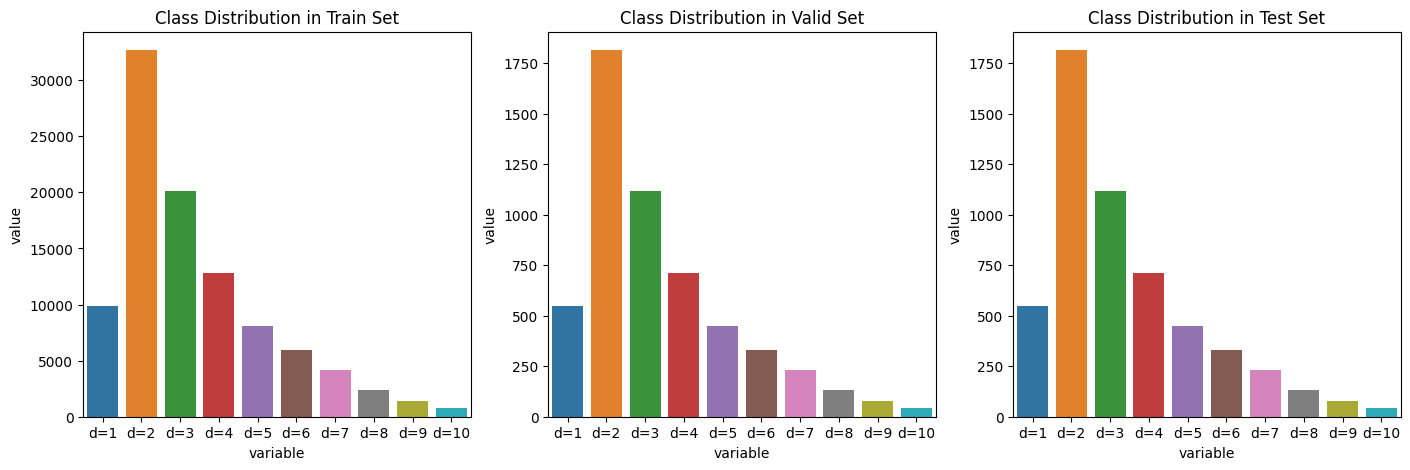

In [44]:
# Check the data splitting and confirm equal stratification in train/test/valid dataset.

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17,5))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train, num_classes)]).melt(), x = "variable", y="value",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_valid, num_classes)]).melt(), x = "variable", y="value",  ax=axes[1]).set_title('Class Distribution in Valid Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test, num_classes)]).melt(), x = "variable", y="value",  ax=axes[2]).set_title('Class Distribution in Test Set')

plt.show()

### 10.3.9 Train a Decision Tree Model

In [45]:
#Before training, define a function to calculate accuracy.

def multi_acc(y_pred, y_test): 
    correct_pred = (y_pred == y_test)
    acc = correct_pred.sum() / len(correct_pred)
    acc = round(acc * 1000) / 1000.
    return acc


In [46]:
print("Start DT Training...")
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train[:], y_train[:])
#print (clf.decision_path(X_valid[0]))
#--------------------------------------------------#
y_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)
#--------------------------------------------------#
test_acc = multi_acc(y_pred, y_test)
train_acc = multi_acc(y_train_pred, y_train)
#--------------------------------------------------#
print("Train Acc: ", train_acc, "Test Acc: ", test_acc )

Start DT Training...
Train Acc:  0.956 Test Acc:  0.597


### 10.3.10 Show Predictive Performance (Confusion Matrix and Classification Report)

[]


100%|██████████████████████████████████████████████████████████████████████████| 5455/5455 [00:00<00:00, 605946.35it/s]


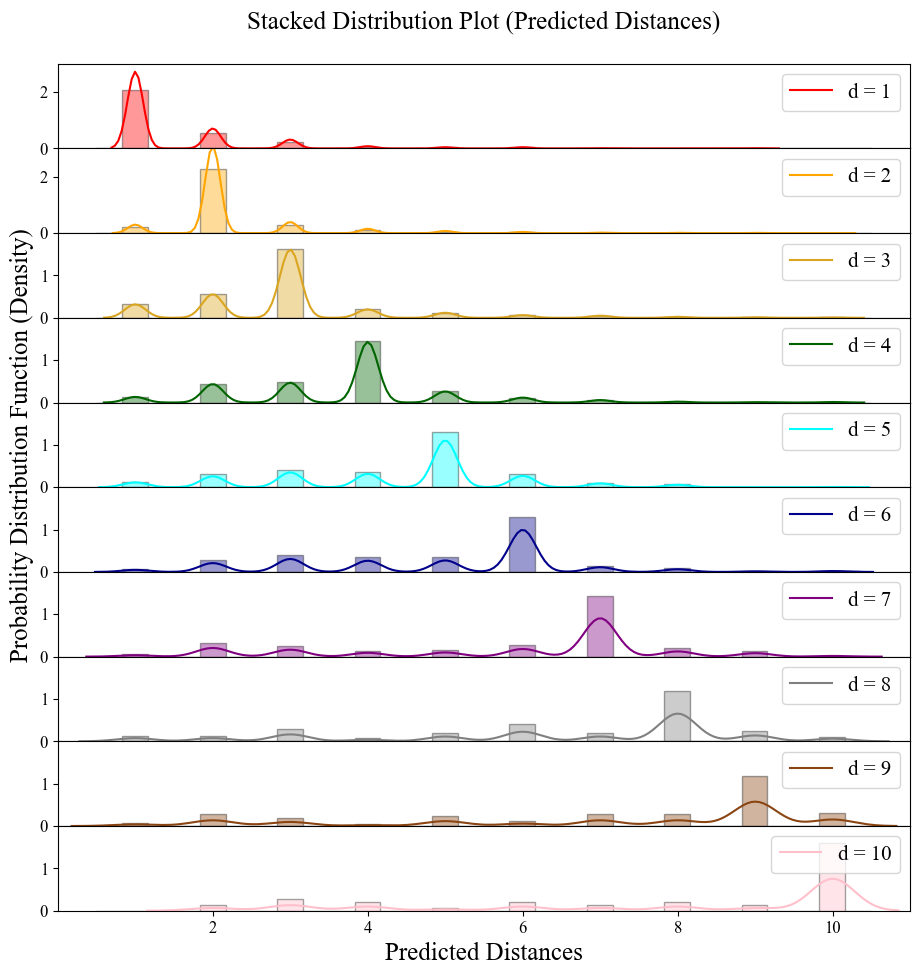

In [47]:
#====================================================================================================#
#num_classes=10
for i in range(num_classes):
    locals()["sim_dist_"+str(i+1)]=[]
print(sim_dist_1)

#====================================================================================================#
for i in tqdm(range(len(y_pred))):
    distance = y_test[i] + 1
    prediction = y_pred[i] + 1
    locals()["sim_dist_"+str(distance)].append(prediction)

#====================================================================================================#
x=[]
for i in range(num_classes):
    x.append(np.array(locals()["sim_dist_"+str(i+1)]))
    
#====================================================================================================#
# For ipynb, remove warnings
import warnings
warnings.filterwarnings('ignore')

#====================================================================================================#
col_list=["red","orange","goldenrod","darkgreen","cyan","darkblue","purple","grey", "saddlebrown", "pink"]

#====================================================================================================#
def plot_type_1(plot_name):
    font = {'family' : "Times New Roman"}
    plt.rc('font', **font)
    g_all = plt.figure(figsize=(num_classes+1, num_classes+1))
    for i in range(num_classes):
        g = plt.subplot(num_classes, 1, i+1)
        #sns.kdeplot(x[i], bw = 0.01 , color="darkred")
        ax = sns.distplot(x[i], hist = 1, bins=np.arange(0.5,10.5,0.333) ,rug=False, kde=True, kde_kws={'bw':0.1},hist_kws=dict(ec="k"), color=col_list[i])
        #sns.distplot(x[i], hist = 1, bins=np.arange(0.5,10.5,0.333), rug=False, kde=True, kde_kws={'bw':0.2},hist_kws=dict(ec="k"), color=col_list[i])
        #sns.distplot(x[i], hist = 1, bins=np.arange(0.5,10.5,0.333), rug=False, kde=True, kde_kws={'bw':0.5},hist_kws=dict(ec="k"), color=col_list[i])
        #--------------------------------------------------#
        g.legend(labels=["d = "+ str(i+1)], fontsize=15, loc='upper right')
        #--------------------------------------------------#
        g.set_yticks([0,1])
        g.set(yticklabels=[0,1])
        g.set_yticks([0,2,4,6]) if (i == 0 or i == 1) else 0
        g.set(yticklabels=[0,2,4,6]) if (i == 0 or i == 1) else 0        
        #--------------------------------------------------#
        g.set_xticks([])
        g.set_xticks([2,4,6,8,10]) if i == num_classes-1 else 0
        g.set(xticklabels=[2,4,6,8,10]) if i == num_classes-1 else 0
        #--------------------------------------------------#
        g.set_ylim((0,2))
        g.set_ylim((0,3)) if (i == 0 or i == 1) else 0       
        g.set_xlim((0, num_classes+1))
        #--------------------------------------------------#
        g.tick_params(axis="y", labelsize=12)
        g.tick_params(axis="x", labelsize=12)
        #--------------------------------------------------#
        g.set(ylabel=None)
        g.set(xlabel=None)
        #--------------------------------------------------#
        g.set_title("Stacked Distribution Plot (Predicted Distances)\n", fontsize=18) if i == 0 else 0
        g.set_ylabel("Probability Distribution Function (Density)", fontsize=18) if i == round(num_classes/2)-1 else 0
        g.set_xlabel("Predicted Distances", fontsize=18) if i == num_classes-1 else 0
    plt.subplots_adjust(wspace=0, hspace=0)   
    plt.show()
    g_all.savefig(results_sub_folder / (output_file_header + ".10_StackedDistn_"+plot_name+".png") , dpi=1000 ) 
    mpl.rcParams.update(mpl.rcParamsDefault)
    return
#====================================================================================================#
plot_name = "PredictedDistance"
plot_type_1("PredictedDistance")




In [48]:
# Compute Spearman's R
print ("R_Prediction = ", round(corrcoef(y_pred,y_test)[1,0],3))

R_Prediction =  0.703


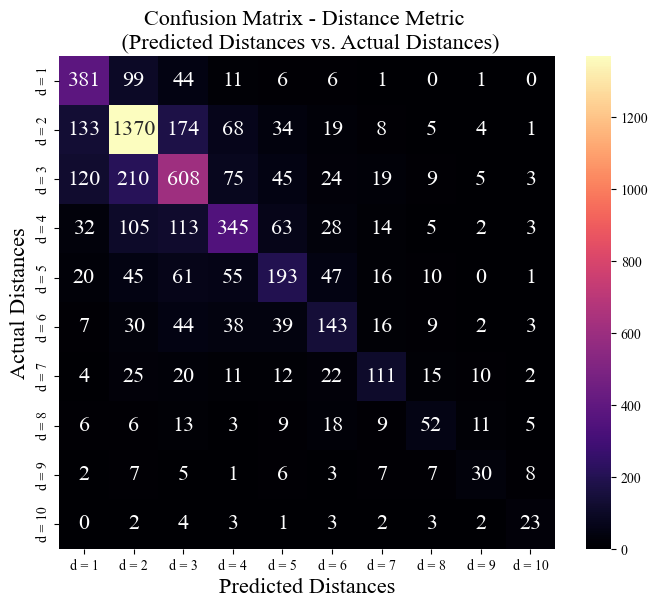

In [49]:
y_pred_list = y_pred
cm=confusion_matrix(y_test, y_pred_list)
confusion_matrix_df = pd.DataFrame(cm).rename(columns=idx2class, index=idx2class)
#--------------------------------------------------#
font = {'family' : "Times New Roman"}
plt.rc('font', **font)
#--------------------------------------------------#
fig = plt.figure(figsize=(8,6.4))
ax = sns.heatmap(confusion_matrix_df, annot=True, cmap="magma", fmt="d", annot_kws={"fontsize":16})
#sns.heatmap(confusion_matrix_df, cmap="Reds", center=550, annot=True, fmt="d", annot_kws={"fontsize":16})
# labels, title and ticks
ax.set_xlabel('Predicted Distances', fontsize = 16)
ax.set_ylabel('Actual Distances', fontsize = 16)
ax.set_title('Confusion Matrix - Distance Metric \n (Predicted Distances vs. Actual Distances)', fontsize = 16)
ax.xaxis.set_ticklabels(["d = " + str(i+1) for i in range(num_classes)])
ax.yaxis.set_ticklabels(["d = " + str(i+1) for i in range(num_classes)])
plt.show()
#--------------------------------------------------#
fig.savefig(results_sub_folder / (output_file_header + ".10_HeatMapCM_" +plot_name+".png" ) , dpi=1000 ) 
mpl.rcParams.update(mpl.rcParamsDefault)
#--------------------------------------------------#

In [50]:
print(classification_report(y_test, y_pred_list)) 

              precision    recall  f1-score   support

           0       0.54      0.69      0.61       549
           1       0.72      0.75      0.74      1816
           2       0.56      0.54      0.55      1118
           3       0.57      0.49      0.52       710
           4       0.47      0.43      0.45       448
           5       0.46      0.43      0.44       331
           6       0.55      0.48      0.51       232
           7       0.45      0.39      0.42       132
           8       0.45      0.39      0.42        76
           9       0.47      0.53      0.50        43

    accuracy                           0.60      5455
   macro avg       0.52      0.51      0.52      5455
weighted avg       0.59      0.60      0.59      5455



### 10.3.12 Visualize how BAD Similarity Score have Characterized Reaction Distances (baseline)

Below shows similarity scores poor characterization of reaction distances.

Similarity Scores are calculated for pairs of compounds with distance information already extracted from MetaNetX compound/reaction database. Different Similarity Metrics are used and shown below including, 

    * "top" 
    * "MACCS" 
    * "atom_pairs" 
    * "vec_pairs" 
    * "torsions" 
    * "ECFP" 
    * "FCFP"

Values of distances are often used to compute an estimated similarity. Similarity scores can then be converted to some "distance" value using the same formula. Here, we estimate "distances" based on each similarity scores and calculate the correlation between the estimated distances and actual reaction distances (minimum steps of reactions required to transform a group of precursors to a target). 

Similarities and distances are oftern converted to one another using the equation, 
![]( https://latex.codecogs.com/svg.latex?\Large&space;similarity(\tau)=\frac{1}{distance(d)+1} ) 


In [51]:
#====================================================================================================#
pickle_in1=open(saving_folder  / "Step07_paired_cmpds_list","rb")
paired_smiles_list=pickle.load(pickle_in1)
pickle_in1.close()
pickle_in2=open(saving_folder  / "Step07_all_pairs_list","rb")
all_pairs_list=pickle.load(pickle_in2)
pickle_in2.close()
#====================================================================================================#
pickle_in1=open(saving_folder  / ("Step08_all_cmpds_"+ECFP_encodings),"rb")
all_smiles=pickle.load(pickle_in1)
pickle_in1.close()
pickle_in2=open(saving_folder  / ("Step08_all_ecfps_"+ECFP_encodings),"rb")
all_ecfps=pickle.load(pickle_in2)
pickle_in2.close()
pickle_in3=open(saving_folder  / ("Step08_all_cmpds_ecfps_dict_"+ECFP_encodings),"rb")
all_smiles_ecfps_dict=pickle.load(pickle_in3)
pickle_in3.close()
#====================================================================================================#
#shuffle(paired_smiles_list)


In [52]:
#====================================================================================================#
def plot_stacked_distribution_similarity_scores(similarity_metric="ECFP", plot_name="Similarity", smiles_list = "paired_smiles_list"):
    dis_list=[]
    sim_list=[]
    sim_inferred_list=[]
    dis_inferred_list=[]
    count_x=0
    
    
    for one_pair_info in tqdm(globals()[smiles_list]): #[   [ { fr{}, fr{} },d ],   [ { fr{}, fr{} },d ],  [{{},{}},d], ....  ]
        count_x+=1
        #print count_x
        if count_x>=200000:
            break
        if len(list(list(one_pair_info[0])))==2:
            score = maxsimscore(list(list(one_pair_info[0])[0]), list(list(one_pair_info[0])[1]), similarity_metric)
            if score != 0:
                #--------------------------------------------------#
                distance = one_pair_info[1]
                dis_list.append(distance)
                #--------------------------------------------------#
                sim_inferred = 1/(distance+1.)
                sim_inferred_list.append(sim_inferred)
                #--------------------------------------------------#
                similarity=score
                sim_list.append(similarity)
                #--------------------------------------------------#
                dis_inferred = round(1./(similarity+0.1) - 1) + 1
                dis_inferred_list.append(dis_inferred)
    #====================================================================================================#
    #num_classes=10
    for i in range(num_classes):
        locals()["sim_dist_"+str(i+1)]=[]
    #====================================================================================================#
    for i in tqdm(range(len(dis_list))):
        distance = dis_list[i] if dis_list[i]<= num_classes-1 else num_classes
        prediction = sim_list[i]
        locals()["sim_dist_"+str(distance)].append(prediction)
    #====================================================================================================#
    x=[]
    for i in range(num_classes):
        x.append(np.array(locals()["sim_dist_"+str(i+1)]))
    #====================================================================================================#
    warnings.filterwarnings('ignore')
    #====================================================================================================#
    col_list=["red", "orange", "goldenrod", "darkgreen", "cyan", "darkblue", "purple", "grey", "saddlebrown", "pink"]
    #====================================================================================================#
    def plot_type_2(plot_name):
        font = {'family' : "Times New Roman"}
        plt.rc('font', **font)
        g_all = plt.figure(figsize=(num_classes+1,num_classes+1))
        for i in range(num_classes):
            g = plt.subplot(num_classes, 1, i+1)
            #sns.kdeplot(x[i], bw = 0.01 , color="darkred")
            #sns.distplot(x[i], hist = 1, bins=np.arange(0.5,10.5,0.333), rug=False, kde=True, kde_kws={'bw':0.1},hist_kws=dict(ec="k"), color=col_list[i])
            sns.distplot(x[i], hist = 1, bins=40, rug=False, kde=True, kde_kws={'bw':0.2},hist_kws=dict(ec="k"), color=col_list[i])
            g.legend(labels=["d = "+ str(i+1)], fontsize=15,loc='upper right')            
            #--------------------------------------------------#
            g2 = plt.plot([mean(x[i])], [0], marker="^", c="red", markersize=20)
            #--------------------------------------------------#
            g.set(xlabel=None)
            g.set(ylabel=None)
            #--------------------------------------------------#
            #g.set_ylim((0,4))
            g.set_yticks([0,1])
            g.set(yticklabels=[0,1])
            g.tick_params(axis="y", labelsize=12)
            #--------------------------------------------------#
            g.set_xlim((0,1))
            g.set_xticks([])
            g.set_xticks([0,0.2,0.4,0.6,0.8,1]) if i == num_classes - 1 else 0
            g.set(xticklabels=[0,0.2,0.4,0.6,0.8,1]) if i == num_classes - 1 else 0
            g.tick_params(axis="x", labelsize=12)
            #--------------------------------------------------#
            g.set_title("Stacked Distribution Plot (Similarity Scores -"\
                        + similarity_metric.upper() \
                        + ")\n", fontsize=18) if i == 0 else 0
            g.set_ylabel("Probability Distribution Function (Density)", fontsize=18) if i == int(num_classes/2.)-1 else 0
            g.set_xlabel("Similarity Scores", fontsize=18) if i == num_classes - 1 else 0
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()
        saving_name = output_file_header + ".12_StackedDistn_" + plot_name + "_" + similarity_metric+".png"
        saving_name = saving_name if smiles_list == "paired_smiles_list" else saving_name.replace(".png", "_test.png")
        g_all.savefig(results_sub_folder / saving_name , dpi=1000 ) 
        mpl.rcParams.update(mpl.rcParamsDefault)
        return
    #====================================================================================================#
    plot_type_2(plot_name)
    #====================================================================================================#
    # Compute Spearman's R
    print ("Compute spearman's R for Distances (Real Distances vs. Inferred Distances) ")
    print ("and Similarities (Similarity Scores vs. Inferred Similarities). ")
    print ("Similarity Metric: ", similarity_metric)
    print ("R_Similarity = ", round(corrcoef(sim_list,sim_inferred_list)[1,0],3))
    print ("R_Distance = ", round(corrcoef(dis_list,dis_inferred_list)[1,0],3))
    #====================================================================================================#
    # Compute Spearman's R
    #--------------------------------------------------#
    font = {'family' : "Times New Roman"}
    plt.rc('font', **font)
    #--------------------------------------------------#
    cm=confusion_matrix(dis_list,dis_inferred_list)
    confusion_matrix_df = pd.DataFrame(cm)
    #--------------------------------------------------#
    fig = plt.figure(figsize=(8,6.4))
    #ax = sns.heatmap(confusion_matrix_df, cmap="Reds", center=550, annot=True, fmt="d", annot_kws={"fontsize":16})
    ax = sns.heatmap(confusion_matrix_df, cmap="magma", annot=True, fmt="d", annot_kws={"fontsize":16})
    ax.set_xlabel('Inferred Distances', fontsize = 16)
    ax.set_ylabel('Actual Distances', fontsize = 16)
    ax.set_title("Confusion Matrix - " \
                 + similarity_metric.upper() \
                 + " \n (Similarity Inferred Distances vs. Actual Distances)", fontsize = 16)
    ax.xaxis.set_ticklabels(["d = " + str(i+1) for i in range(num_classes)])
    ax.yaxis.set_ticklabels(["d = " + str(i+1) for i in range(num_classes)])
    plt.show()
    #--------------------------------------------------#
    saving_name = output_file_header + ".12_HeatMapCM_" + plot_name + "_" + similarity_metric+".png"
    saving_name = saving_name if smiles_list == "paired_smiles_list" else saving_name.replace(".png", "_test.png")
    fig.savefig(results_sub_folder / saving_name , dpi=1000 )
    mpl.rcParams.update(mpl.rcParamsDefault)
    #====================================================================================================#
    print("\nClassification Report\n")
    print(classification_report(dis_list, dis_inferred_list)) 


### ECFP-based Similarity Metric's Characterization of Reaction Distances

100%|██████████████████████████████████████████████████████████████████████| 106482/106482 [00:00<00:00, 724203.71it/s]


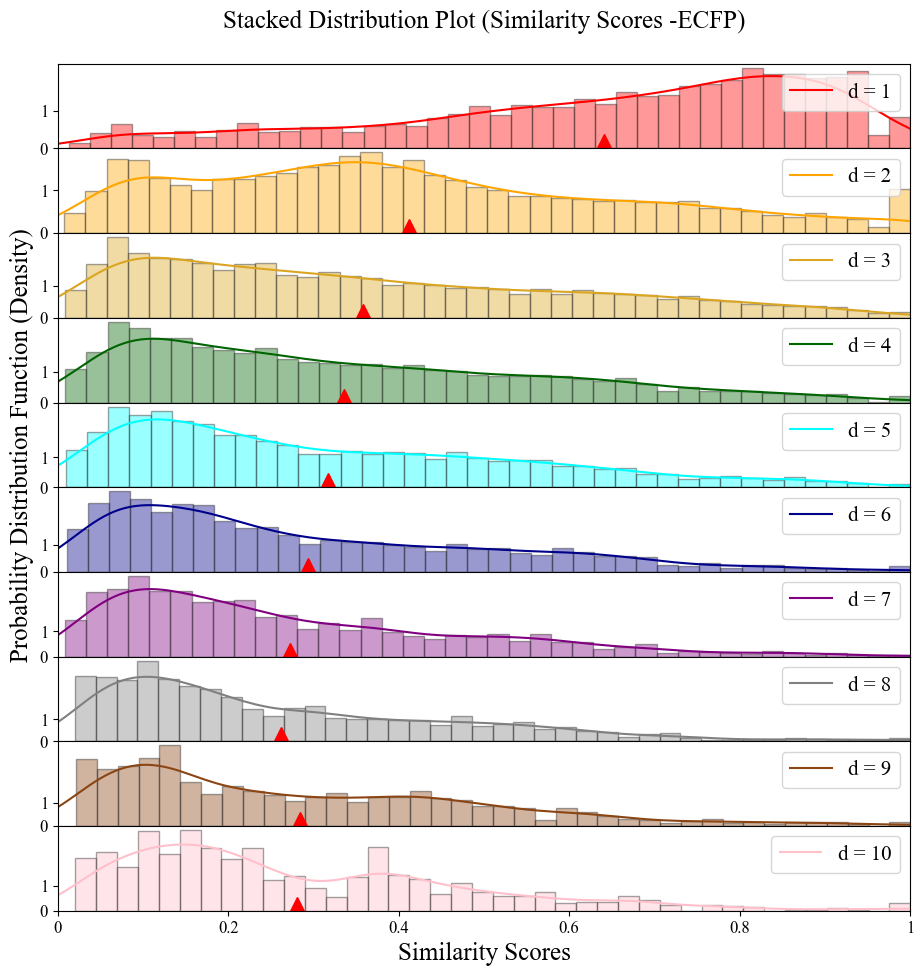

Compute spearman's R for Distances (Real Distances vs. Inferred Distances) 
and Similarities (Similarity Scores vs. Inferred Similarities). 
Similarity Metric:  ECFP
R_Similarity =  0.359
R_Distance =  0.244


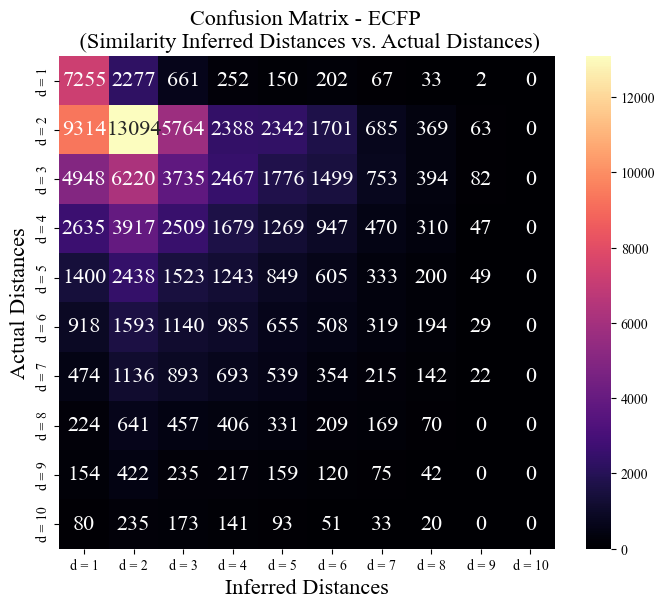


Classification Report

              precision    recall  f1-score   support

           1       0.26      0.67      0.38     10899
           2       0.41      0.37      0.39     35720
           3       0.22      0.17      0.19     21874
           4       0.16      0.12      0.14     13783
           5       0.10      0.10      0.10      8640
           6       0.08      0.08      0.08      6341
           7       0.07      0.05      0.06      4468
           8       0.04      0.03      0.03      2507
           9       0.00      0.00      0.00      1424
          10       0.00      0.00      0.00       826

    accuracy                           0.26    106482
   macro avg       0.13      0.16      0.14    106482
weighted avg       0.25      0.26      0.24    106482



In [53]:
#====================================================================================================#
plot_stacked_distribution_similarity_scores(similarity_metric="ECFP", plot_name="Similarity")

### Other Similarity Metric's Characterization of Reaction Distances

100%|██████████████████████████████████████████████████████████████████████| 108885/108885 [00:00<00:00, 711482.08it/s]


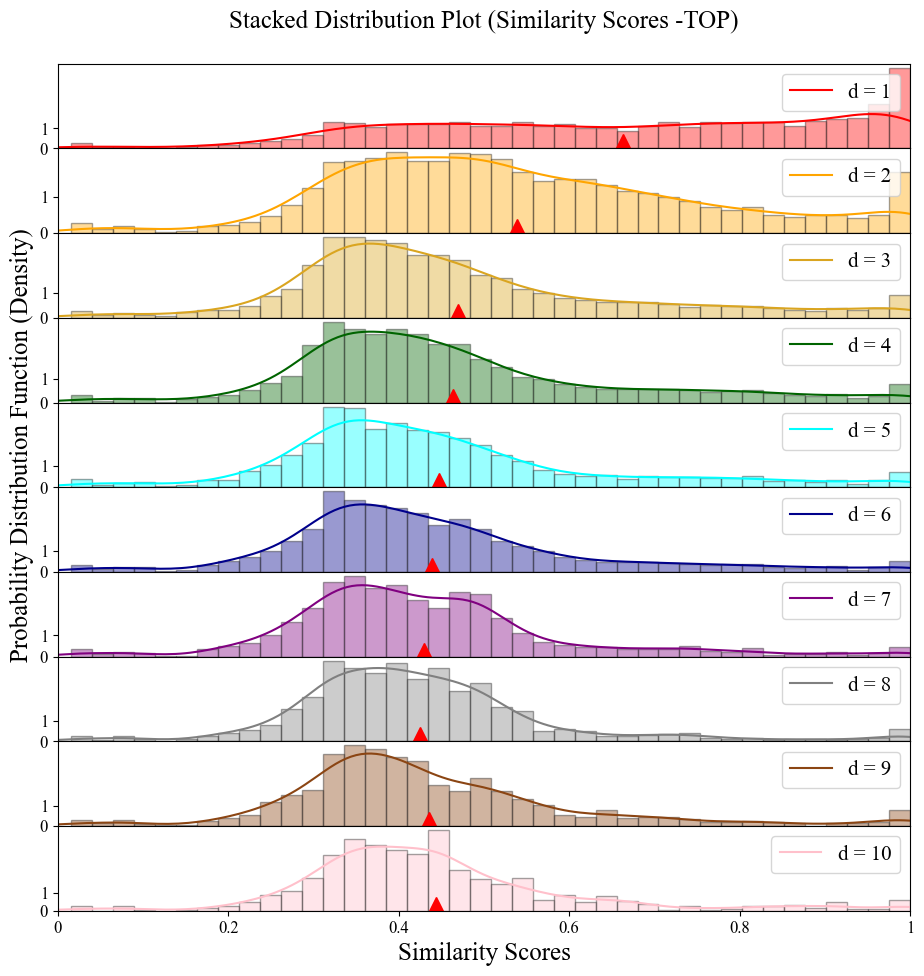

Compute spearman's R for Distances (Real Distances vs. Inferred Distances) 
and Similarities (Similarity Scores vs. Inferred Similarities). 
Similarity Metric:  top
R_Similarity =  0.309
R_Distance =  0.16


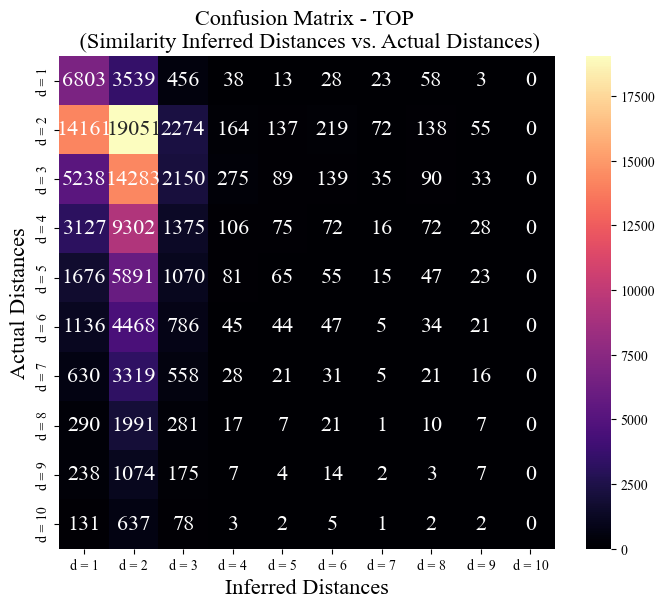


Classification Report

              precision    recall  f1-score   support

           1       0.20      0.62      0.31     10961
           2       0.30      0.53      0.38     36271
           3       0.23      0.10      0.14     22332
           4       0.14      0.01      0.01     14173
           5       0.14      0.01      0.01      8923
           6       0.07      0.01      0.01      6586
           7       0.03      0.00      0.00      4629
           8       0.02      0.00      0.01      2625
           9       0.04      0.00      0.01      1524
          10       0.00      0.00      0.00       861

    accuracy                           0.26    108885
   macro avg       0.12      0.13      0.09    108885
weighted avg       0.20      0.26      0.19    108885



In [54]:
#====================================================================================================#
plot_stacked_distribution_similarity_scores(similarity_metric="top", plot_name="Similarity")

100%|██████████████████████████████████████████████████████████████████████| 108656/108656 [00:00<00:00, 700881.52it/s]


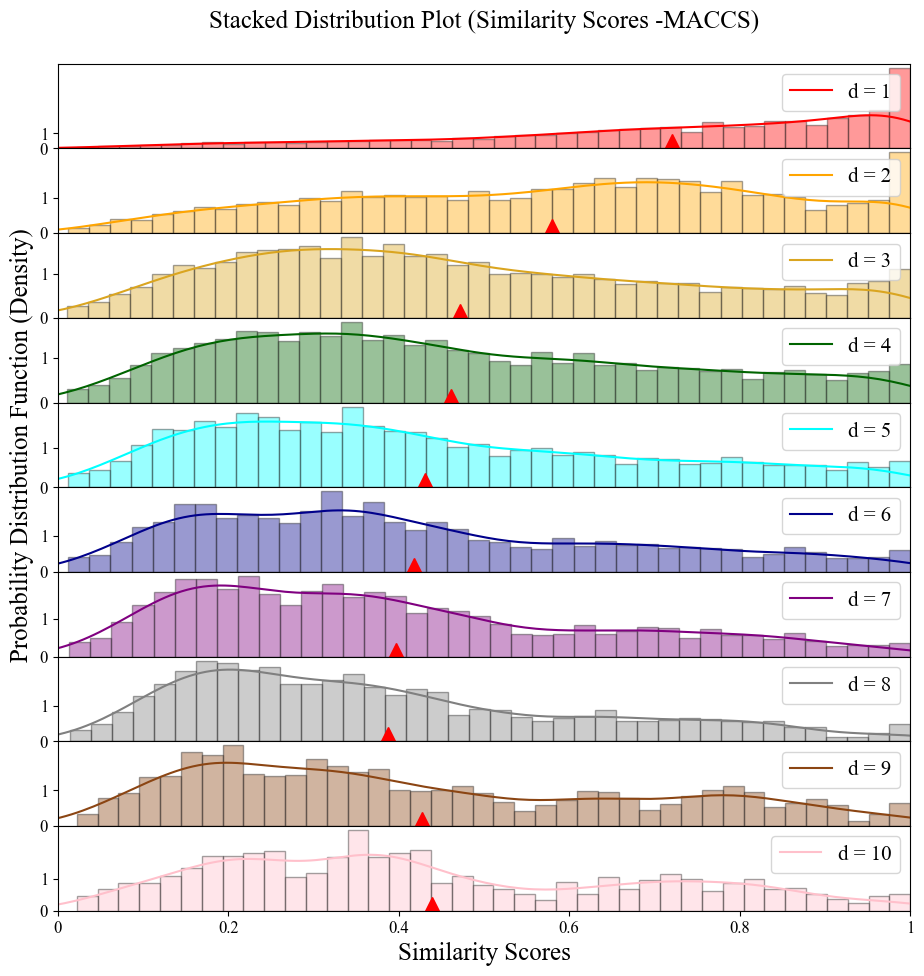

Compute spearman's R for Distances (Real Distances vs. Inferred Distances) 
and Similarities (Similarity Scores vs. Inferred Similarities). 
Similarity Metric:  MACCS
R_Similarity =  0.342
R_Distance =  0.236


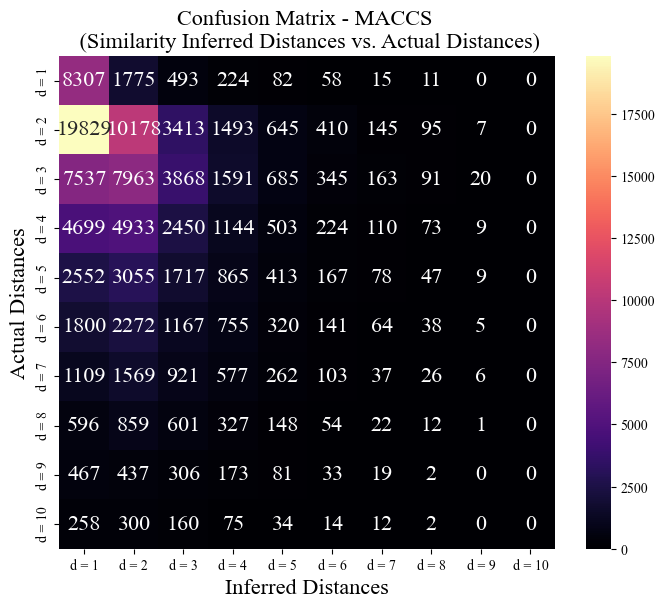


Classification Report

              precision    recall  f1-score   support

           1       0.18      0.76      0.29     10965
           2       0.31      0.28      0.29     36215
           3       0.26      0.17      0.21     22263
           4       0.16      0.08      0.11     14145
           5       0.13      0.05      0.07      8903
           6       0.09      0.02      0.03      6562
           7       0.06      0.01      0.01      4610
           8       0.03      0.00      0.01      2620
           9       0.00      0.00      0.00      1518
          10       0.00      0.00      0.00       855

    accuracy                           0.22    108656
   macro avg       0.12      0.14      0.10    108656
weighted avg       0.21      0.22      0.19    108656



In [55]:
#====================================================================================================#
plot_stacked_distribution_similarity_scores(similarity_metric="MACCS", plot_name="Similarity")

100%|██████████████████████████████████████████████████████████████████████| 107903/107903 [00:00<00:00, 714426.86it/s]


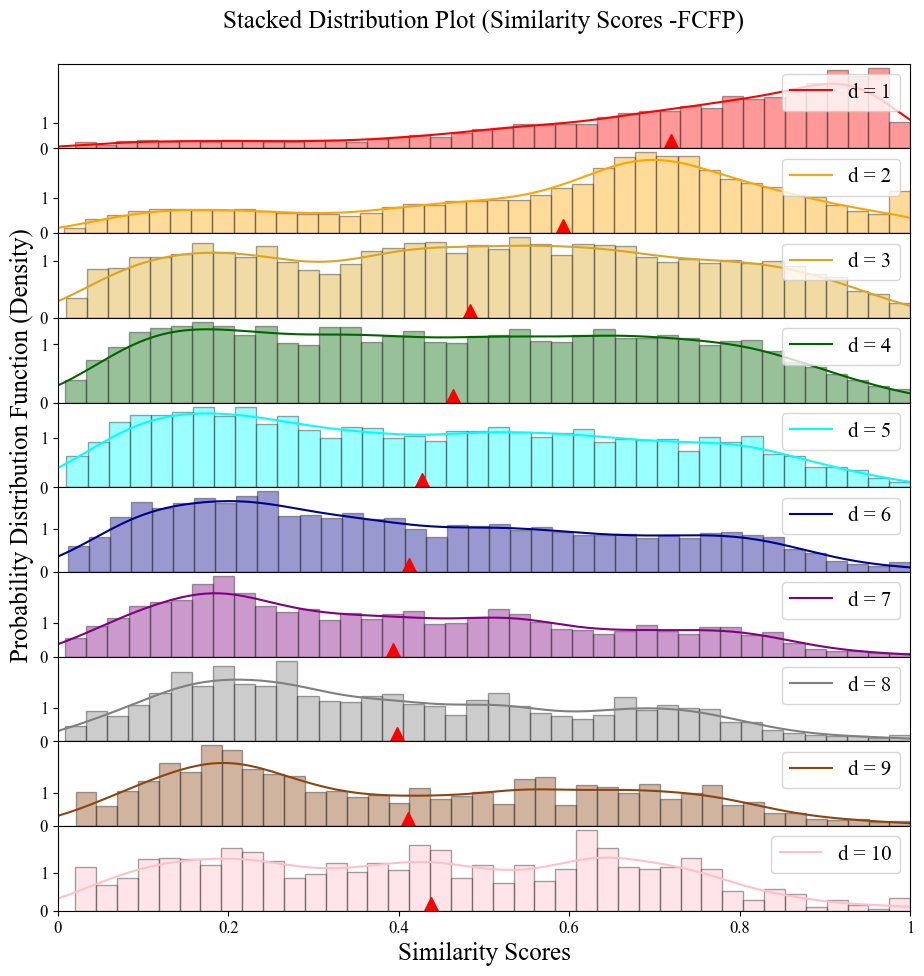

Compute spearman's R for Distances (Real Distances vs. Inferred Distances) 
and Similarities (Similarity Scores vs. Inferred Similarities). 
Similarity Metric:  FCFP
R_Similarity =  0.354
R_Distance =  0.235


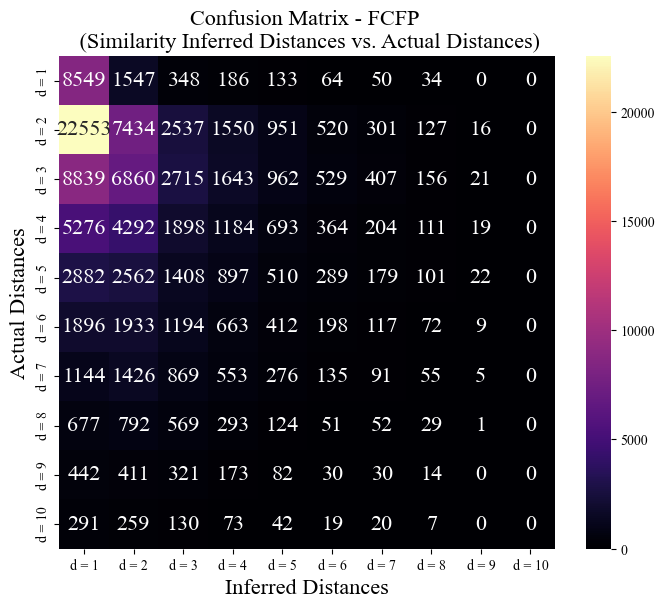


Classification Report

              precision    recall  f1-score   support

           1       0.16      0.78      0.27     10911
           2       0.27      0.21      0.23     35989
           3       0.23      0.12      0.16     22132
           4       0.16      0.08      0.11     14041
           5       0.12      0.06      0.08      8850
           6       0.09      0.03      0.05      6494
           7       0.06      0.02      0.03      4554
           8       0.04      0.01      0.02      2588
           9       0.00      0.00      0.00      1503
          10       0.00      0.00      0.00       841

    accuracy                           0.19    107903
   macro avg       0.11      0.13      0.09    107903
weighted avg       0.19      0.19      0.16    107903



In [56]:
#====================================================================================================#
plot_stacked_distribution_similarity_scores(similarity_metric="FCFP", plot_name="Similarity")

100%|██████████████████████████████████████████████████████████████████████| 104718/104718 [00:00<00:00, 717083.09it/s]


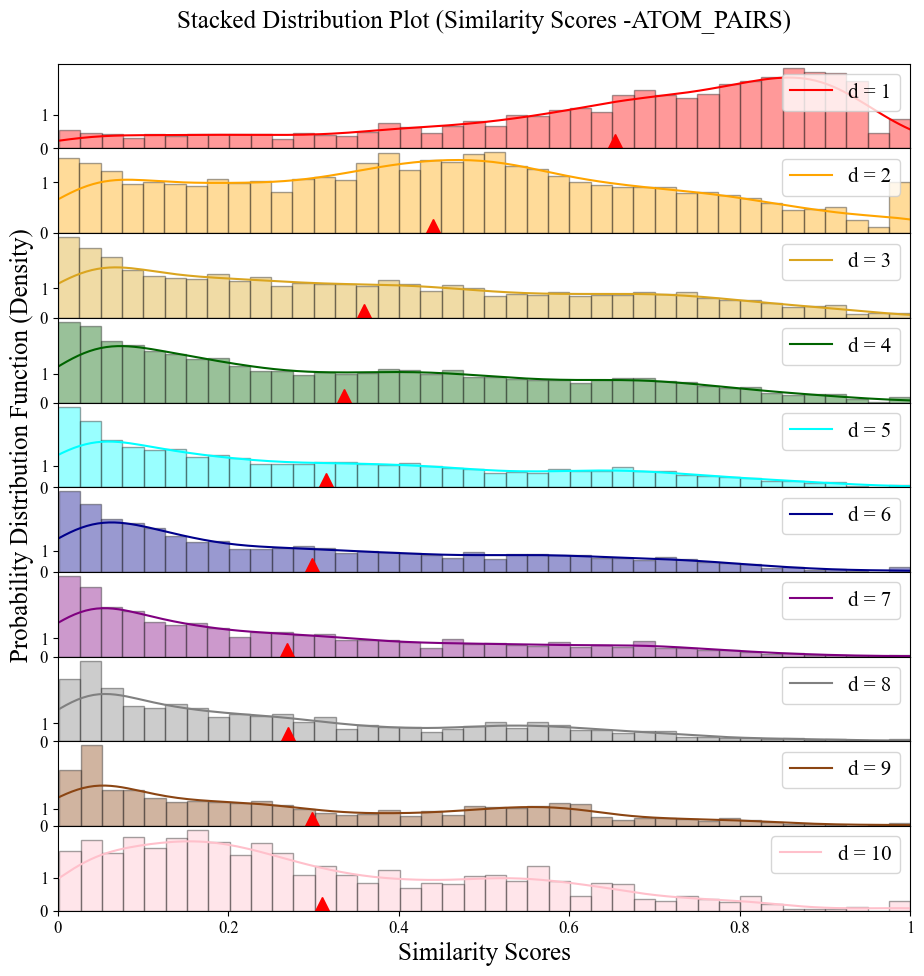

Compute spearman's R for Distances (Real Distances vs. Inferred Distances) 
and Similarities (Similarity Scores vs. Inferred Similarities). 
Similarity Metric:  atom_pairs
R_Similarity =  0.363
R_Distance =  0.246


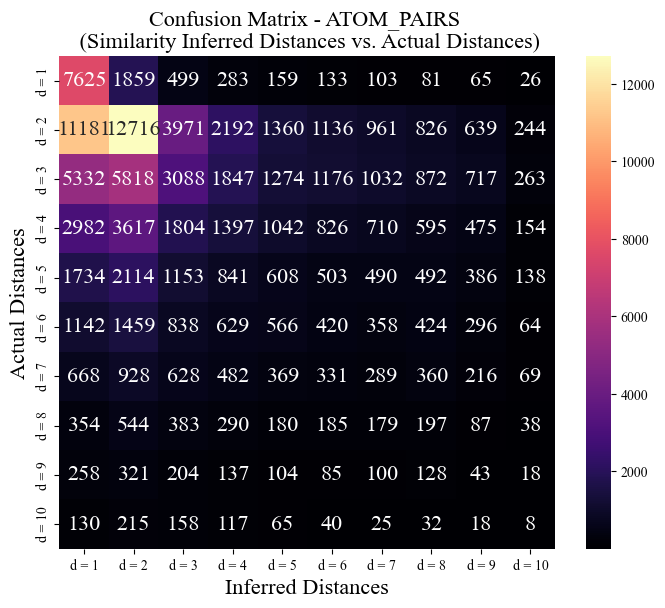


Classification Report

              precision    recall  f1-score   support

           1       0.24      0.70      0.36     10833
           2       0.43      0.36      0.39     35226
           3       0.24      0.14      0.18     21419
           4       0.17      0.10      0.13     13602
           5       0.11      0.07      0.09      8459
           6       0.09      0.07      0.08      6196
           7       0.07      0.07      0.07      4340
           8       0.05      0.08      0.06      2437
           9       0.01      0.03      0.02      1398
          10       0.01      0.01      0.01       808

    accuracy                           0.25    104718
   macro avg       0.14      0.16      0.14    104718
weighted avg       0.26      0.25      0.24    104718



In [57]:
#====================================================================================================#
plot_stacked_distribution_similarity_scores(similarity_metric="atom_pairs", plot_name="Similarity")

100%|██████████████████████████████████████████████████████████████████████| 104718/104718 [00:00<00:00, 727044.35it/s]


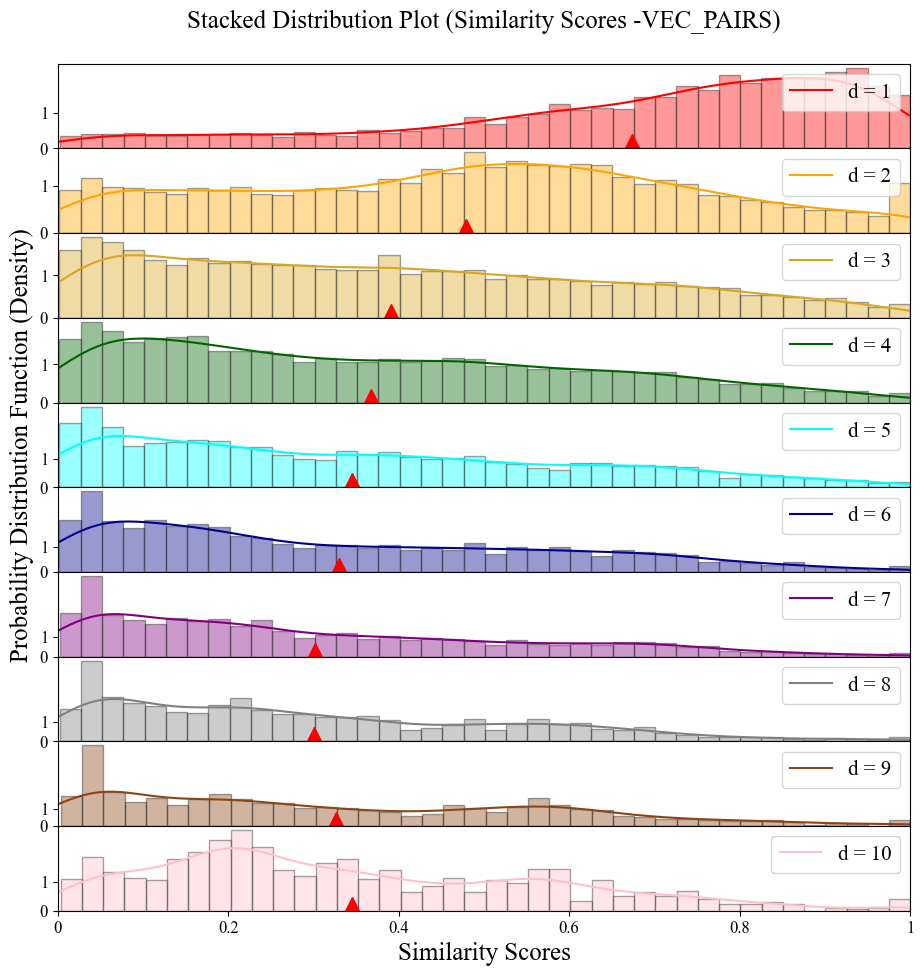

Compute spearman's R for Distances (Real Distances vs. Inferred Distances) 
and Similarities (Similarity Scores vs. Inferred Similarities). 
Similarity Metric:  vec_pairs
R_Similarity =  0.359
R_Distance =  0.236


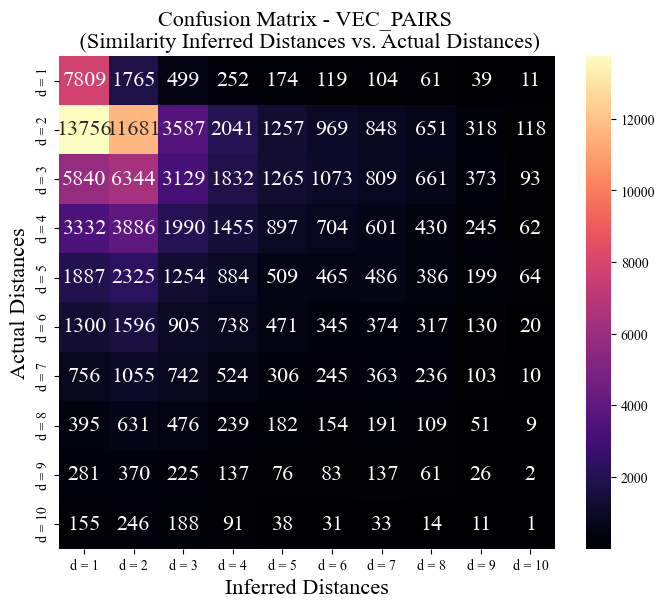


Classification Report

              precision    recall  f1-score   support

           1       0.22      0.72      0.34     10833
           2       0.39      0.33      0.36     35226
           3       0.24      0.15      0.18     21419
           4       0.18      0.11      0.13     13602
           5       0.10      0.06      0.07      8459
           6       0.08      0.06      0.07      6196
           7       0.09      0.08      0.09      4340
           8       0.04      0.04      0.04      2437
           9       0.02      0.02      0.02      1398
          10       0.00      0.00      0.00       808

    accuracy                           0.24    104718
   macro avg       0.14      0.16      0.13    104718
weighted avg       0.24      0.24      0.22    104718



In [58]:
#====================================================================================================#
plot_stacked_distribution_similarity_scores(similarity_metric="vec_pairs", plot_name="Similarity")

100%|████████████████████████████████████████████████████████████████████████| 79864/79864 [00:00<00:00, 706552.88it/s]


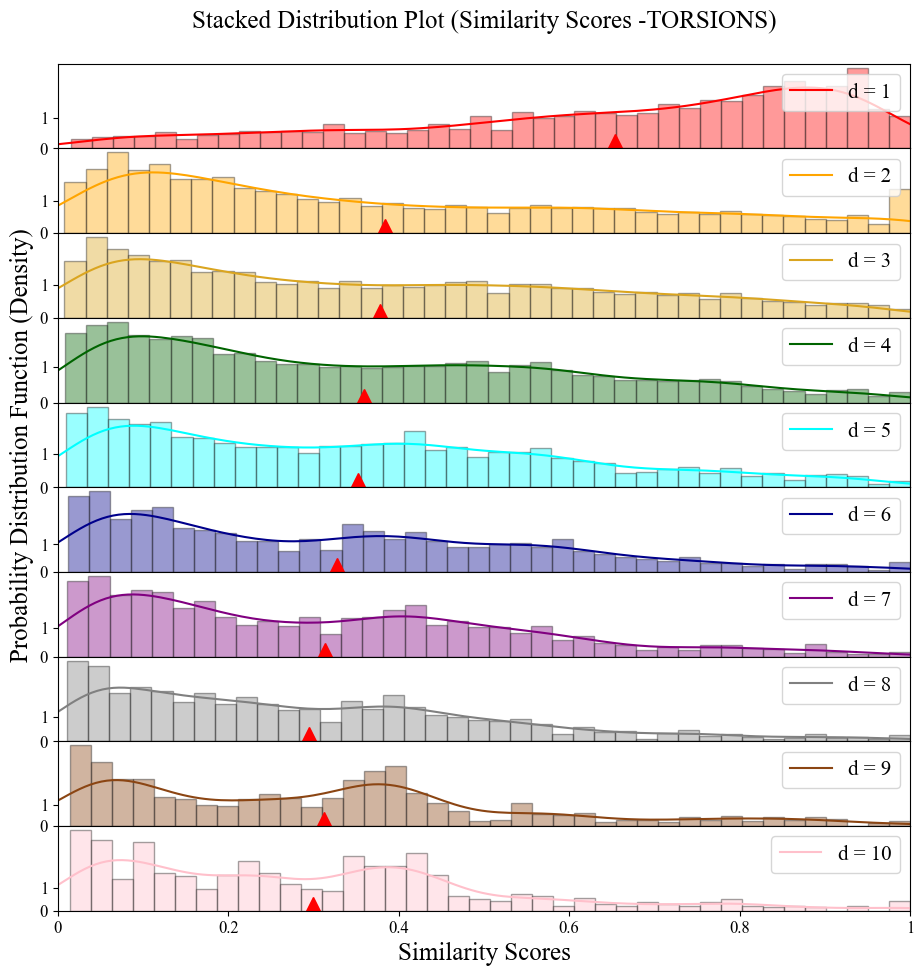

Compute spearman's R for Distances (Real Distances vs. Inferred Distances) 
and Similarities (Similarity Scores vs. Inferred Similarities). 
Similarity Metric:  torsions
R_Similarity =  0.295
R_Distance =  0.158


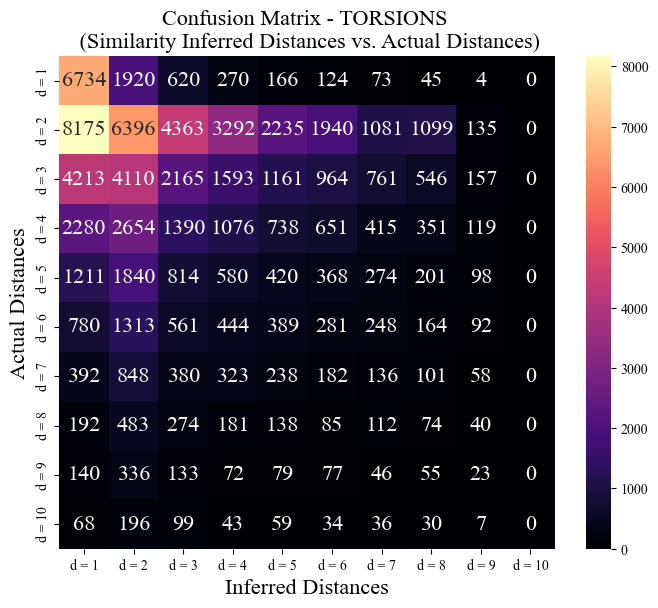


Classification Report

              precision    recall  f1-score   support

           1       0.28      0.68      0.39      9956
           2       0.32      0.22      0.26     28716
           3       0.20      0.14      0.16     15670
           4       0.14      0.11      0.12      9674
           5       0.07      0.07      0.07      5806
           6       0.06      0.07      0.06      4272
           7       0.04      0.05      0.05      2658
           8       0.03      0.05      0.03      1579
           9       0.03      0.02      0.03       961
          10       0.00      0.00      0.00       572

    accuracy                           0.22     79864
   macro avg       0.12      0.14      0.12     79864
weighted avg       0.22      0.22      0.20     79864



In [59]:
#====================================================================================================#
plot_stacked_distribution_similarity_scores(similarity_metric="torsions", plot_name="Similarity")

### ECFP-based Similarity Metric's Characterization of Reaction Distances for test set

In [60]:
for one_pair_info in paired_smiles_list:
    if len(one_pair_info[0])!=2:
        #print (one_pair_info[0])
        #print ("unexpected error: source and target compound are exactly the same and with non-zero reaction distance.")
        paired_smiles_list.remove(one_pair_info)
print ("screened!")

smiles_train, smiles_test, y_train, y_test = train_test_split(paired_smiles_list, 
                                                              y_data, 
                                                              test_size=0.1, 
                                                              stratify=y_data, 
                                                              random_state=42)

smiles_valid, smiles_test, y_valid, y_test = train_test_split(smiles_test, 
                                                              y_test, 
                                                              test_size=0.5, 
                                                              stratify=y_test, 
                                                              random_state=42)

screened!


100%|██████████████████████████████████████████████████████████████████████████| 5342/5342 [00:00<00:00, 667579.54it/s]


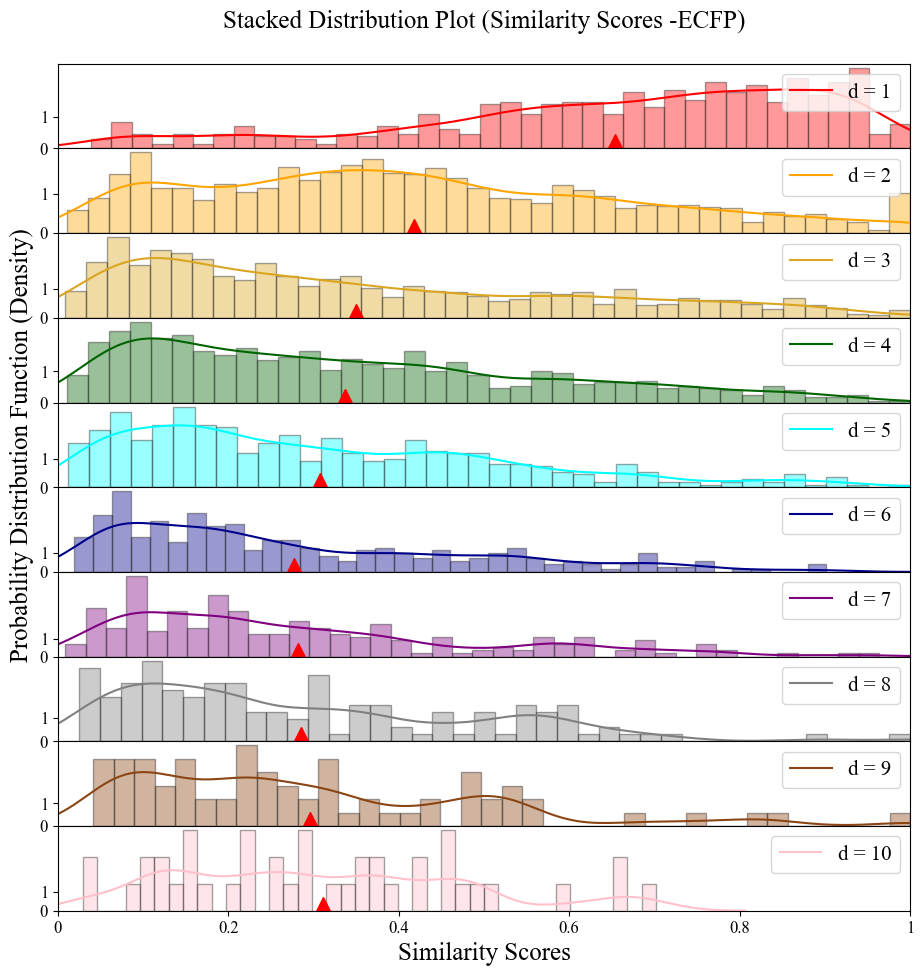

Compute spearman's R for Distances (Real Distances vs. Inferred Distances) 
and Similarities (Similarity Scores vs. Inferred Similarities). 
Similarity Metric:  ECFP
R_Similarity =  0.374
R_Distance =  0.234


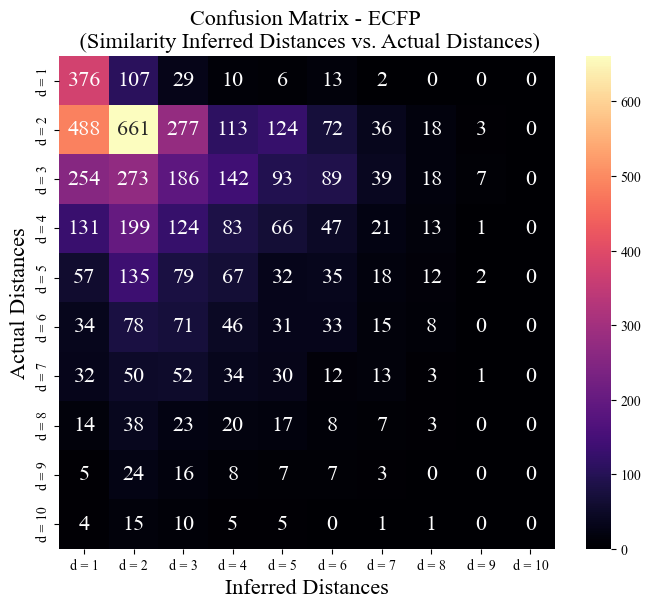


Classification Report

              precision    recall  f1-score   support

           1       0.27      0.69      0.39       543
           2       0.42      0.37      0.39      1792
           3       0.21      0.17      0.19      1101
           4       0.16      0.12      0.14       685
           5       0.08      0.07      0.08       437
           6       0.10      0.10      0.10       316
           7       0.08      0.06      0.07       227
           8       0.04      0.02      0.03       130
           9       0.00      0.00      0.00        70
          10       0.00      0.00      0.00        41

    accuracy                           0.26      5342
   macro avg       0.14      0.16      0.14      5342
weighted avg       0.25      0.26      0.24      5342



In [61]:
plot_stacked_distribution_similarity_scores(similarity_metric="ECFP", 
                                            plot_name="Similarity",
                                            smiles_list="smiles_test")

100%|██████████████████████████████████████████████████████████████████████████| 5448/5448 [00:00<00:00, 680887.01it/s]


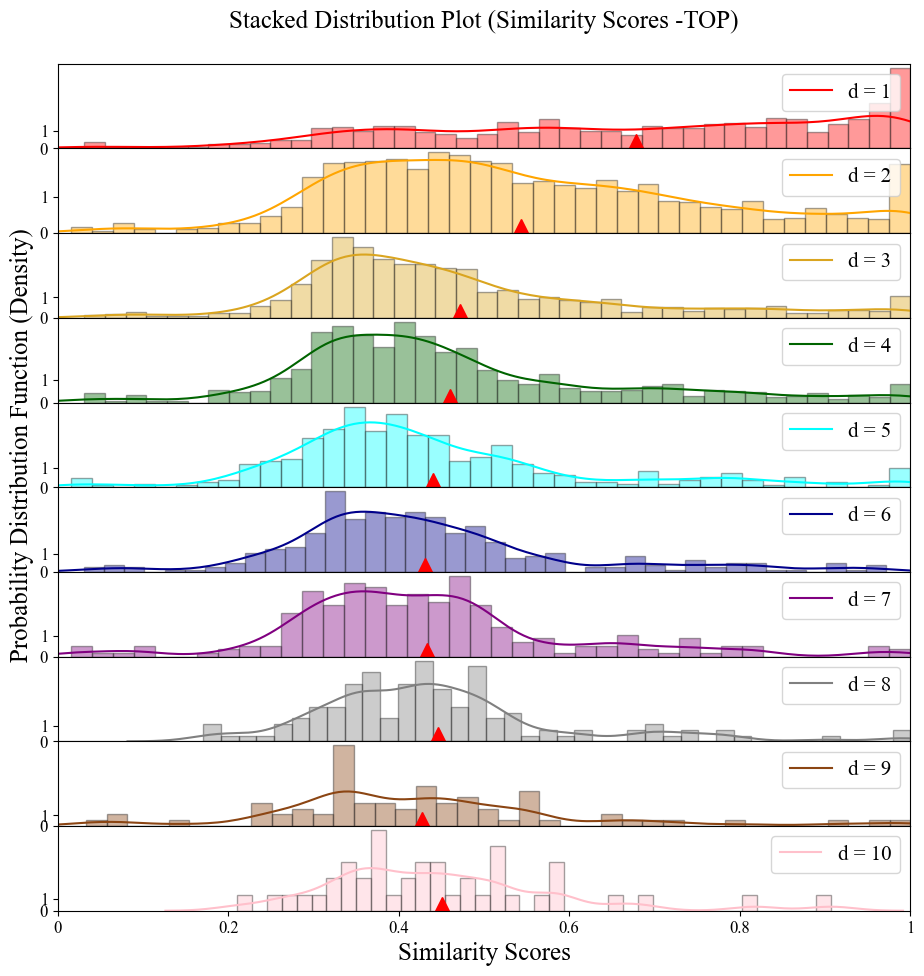

Compute spearman's R for Distances (Real Distances vs. Inferred Distances) 
and Similarities (Similarity Scores vs. Inferred Similarities). 
Similarity Metric:  top
R_Similarity =  0.328
R_Distance =  0.177


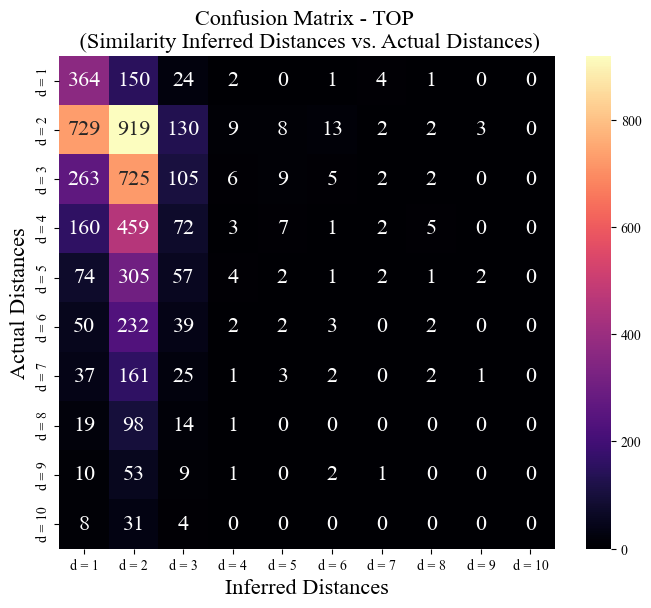


Classification Report

              precision    recall  f1-score   support

           1       0.21      0.67      0.32       546
           2       0.29      0.51      0.37      1815
           3       0.22      0.09      0.13      1117
           4       0.10      0.00      0.01       709
           5       0.06      0.00      0.01       448
           6       0.11      0.01      0.02       330
           7       0.00      0.00      0.00       232
           8       0.00      0.00      0.00       132
           9       0.00      0.00      0.00        76
          10       0.00      0.00      0.00        43

    accuracy                           0.26      5448
   macro avg       0.10      0.13      0.09      5448
weighted avg       0.19      0.26      0.19      5448



In [62]:
plot_stacked_distribution_similarity_scores(similarity_metric="top", 
                                            plot_name="Similarity",
                                            smiles_list="smiles_test")

100%|██████████████████████████████████████████████████████████████████████████| 5438/5438 [00:00<00:00, 678868.54it/s]


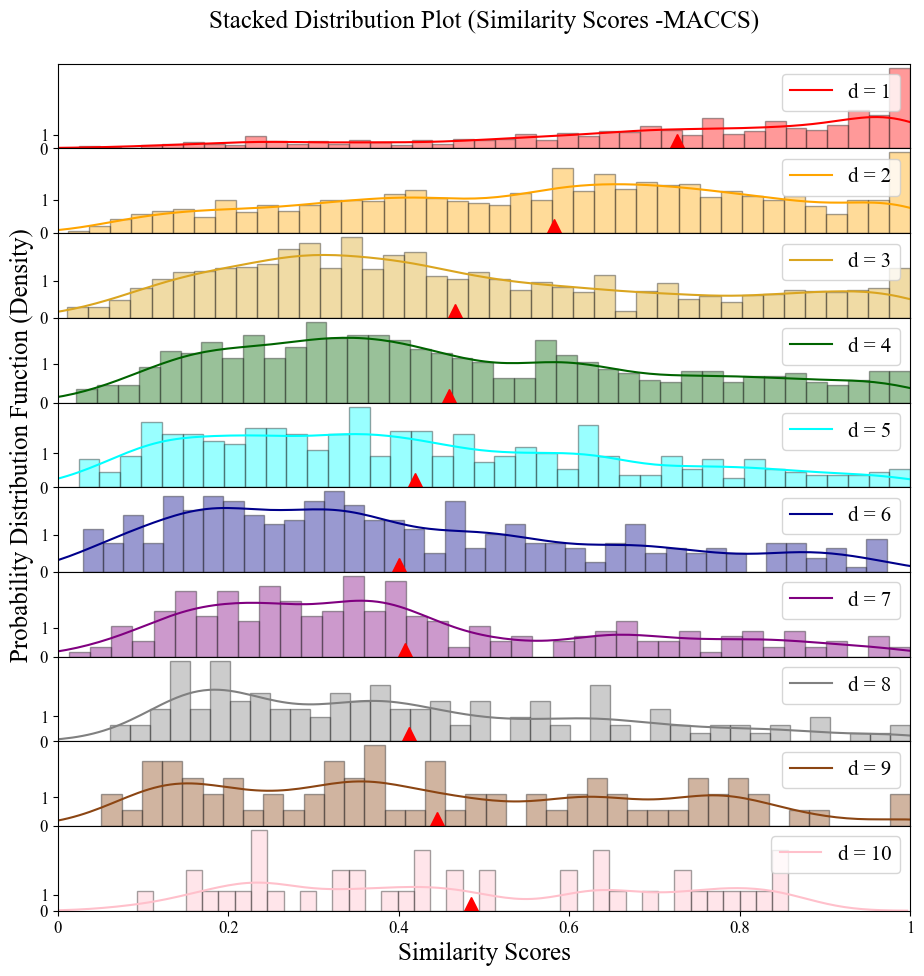

Compute spearman's R for Distances (Real Distances vs. Inferred Distances) 
and Similarities (Similarity Scores vs. Inferred Similarities). 
Similarity Metric:  MACCS
R_Similarity =  0.347
R_Distance =  0.226


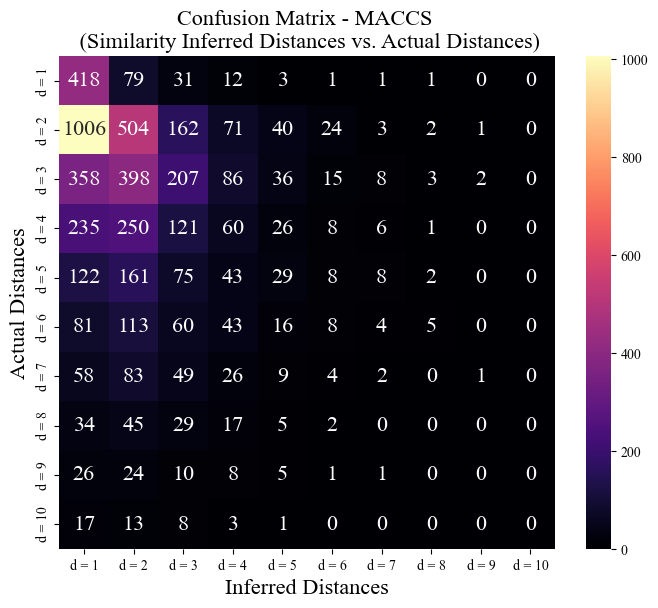


Classification Report

              precision    recall  f1-score   support

           1       0.18      0.77      0.29       546
           2       0.30      0.28      0.29      1813
           3       0.28      0.19      0.22      1113
           4       0.16      0.08      0.11       707
           5       0.17      0.06      0.09       448
           6       0.11      0.02      0.04       330
           7       0.06      0.01      0.02       232
           8       0.00      0.00      0.00       132
           9       0.00      0.00      0.00        75
          10       0.00      0.00      0.00        42

    accuracy                           0.23      5438
   macro avg       0.13      0.14      0.11      5438
weighted avg       0.22      0.23      0.20      5438



In [63]:
plot_stacked_distribution_similarity_scores(similarity_metric="MACCS", 
                                            plot_name="Similarity",
                                            smiles_list="smiles_test")

100%|██████████████████████████████████████████████████████████████████████████| 5405/5405 [00:00<00:00, 674748.89it/s]


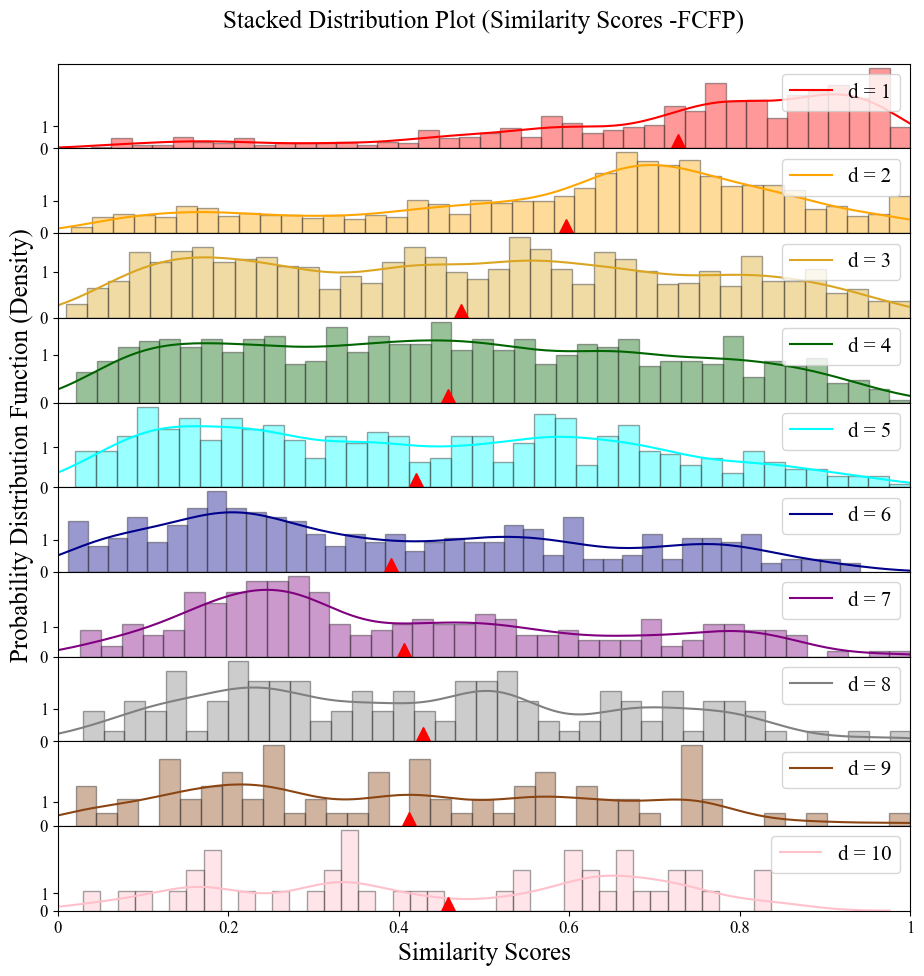

Compute spearman's R for Distances (Real Distances vs. Inferred Distances) 
and Similarities (Similarity Scores vs. Inferred Similarities). 
Similarity Metric:  FCFP
R_Similarity =  0.366
R_Distance =  0.234


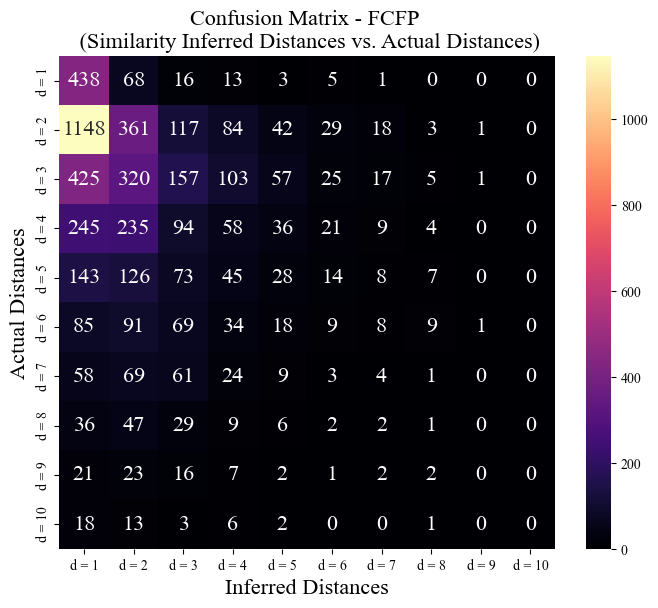


Classification Report

              precision    recall  f1-score   support

           1       0.17      0.81      0.28       544
           2       0.27      0.20      0.23      1803
           3       0.25      0.14      0.18      1110
           4       0.15      0.08      0.11       702
           5       0.14      0.06      0.09       444
           6       0.08      0.03      0.04       324
           7       0.06      0.02      0.03       229
           8       0.03      0.01      0.01       132
           9       0.00      0.00      0.00        74
          10       0.00      0.00      0.00        43

    accuracy                           0.20      5405
   macro avg       0.11      0.13      0.10      5405
weighted avg       0.20      0.20      0.17      5405



In [64]:
plot_stacked_distribution_similarity_scores(similarity_metric="FCFP", 
                                            plot_name="Similarity",
                                            smiles_list="smiles_test")


100%|██████████████████████████████████████████████████████████████████████████| 5235/5235 [00:00<00:00, 654266.43it/s]


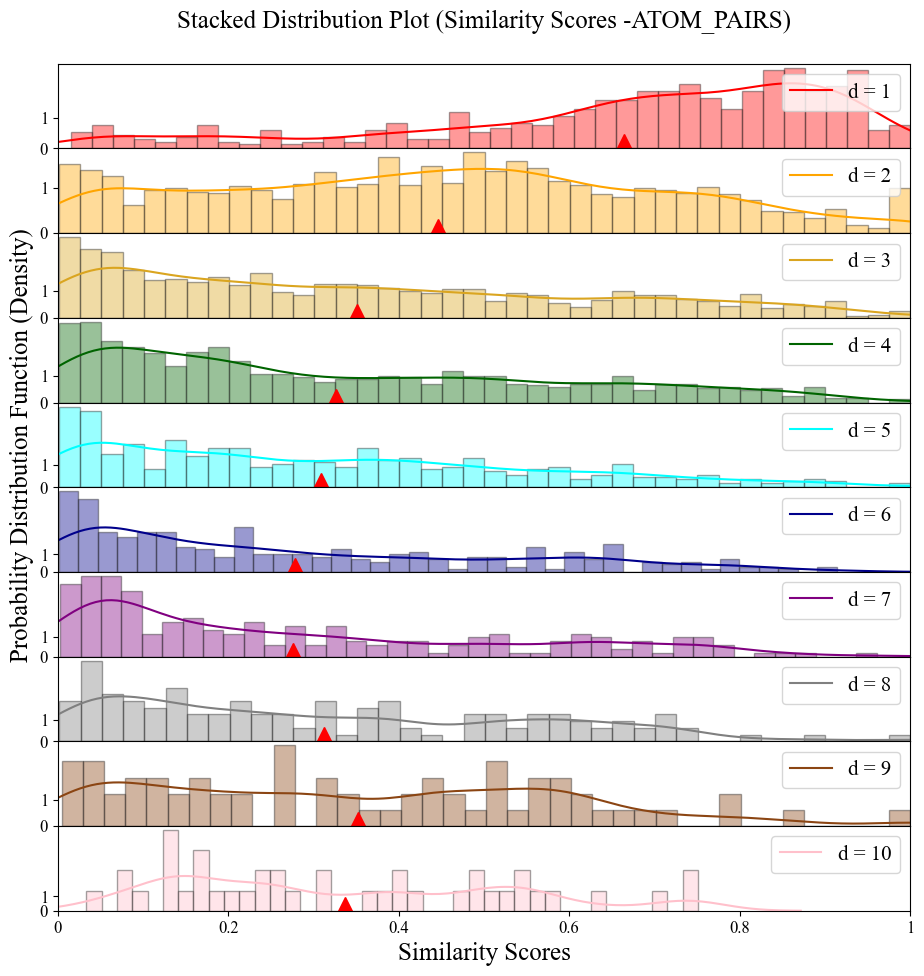

Compute spearman's R for Distances (Real Distances vs. Inferred Distances) 
and Similarities (Similarity Scores vs. Inferred Similarities). 
Similarity Metric:  atom_pairs
R_Similarity =  0.372
R_Distance =  0.227


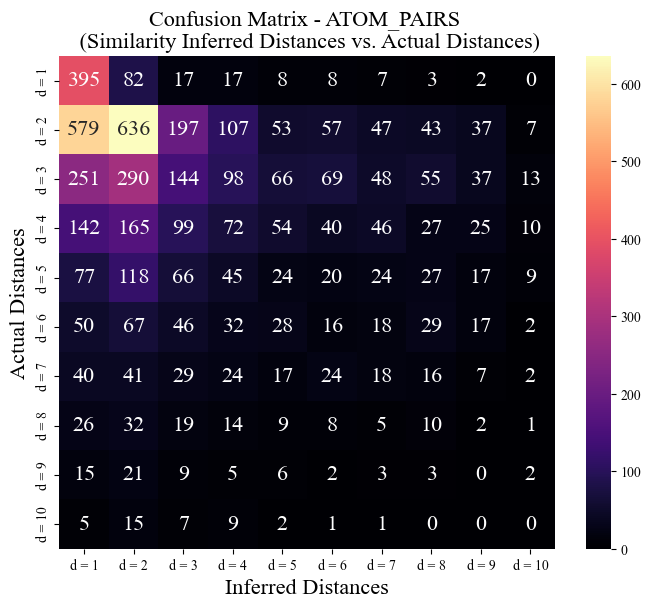


Classification Report

              precision    recall  f1-score   support

           1       0.25      0.73      0.37       539
           2       0.43      0.36      0.39      1763
           3       0.23      0.13      0.17      1071
           4       0.17      0.11      0.13       680
           5       0.09      0.06      0.07       427
           6       0.07      0.05      0.06       305
           7       0.08      0.08      0.08       218
           8       0.05      0.08      0.06       126
           9       0.00      0.00      0.00        66
          10       0.00      0.00      0.00        40

    accuracy                           0.25      5235
   macro avg       0.14      0.16      0.13      5235
weighted avg       0.26      0.25      0.24      5235



In [65]:
plot_stacked_distribution_similarity_scores(similarity_metric="atom_pairs", 
                                            plot_name="Similarity",
                                            smiles_list="smiles_test")

100%|██████████████████████████████████████████████████████████████████████████| 5235/5235 [00:00<00:00, 654246.94it/s]


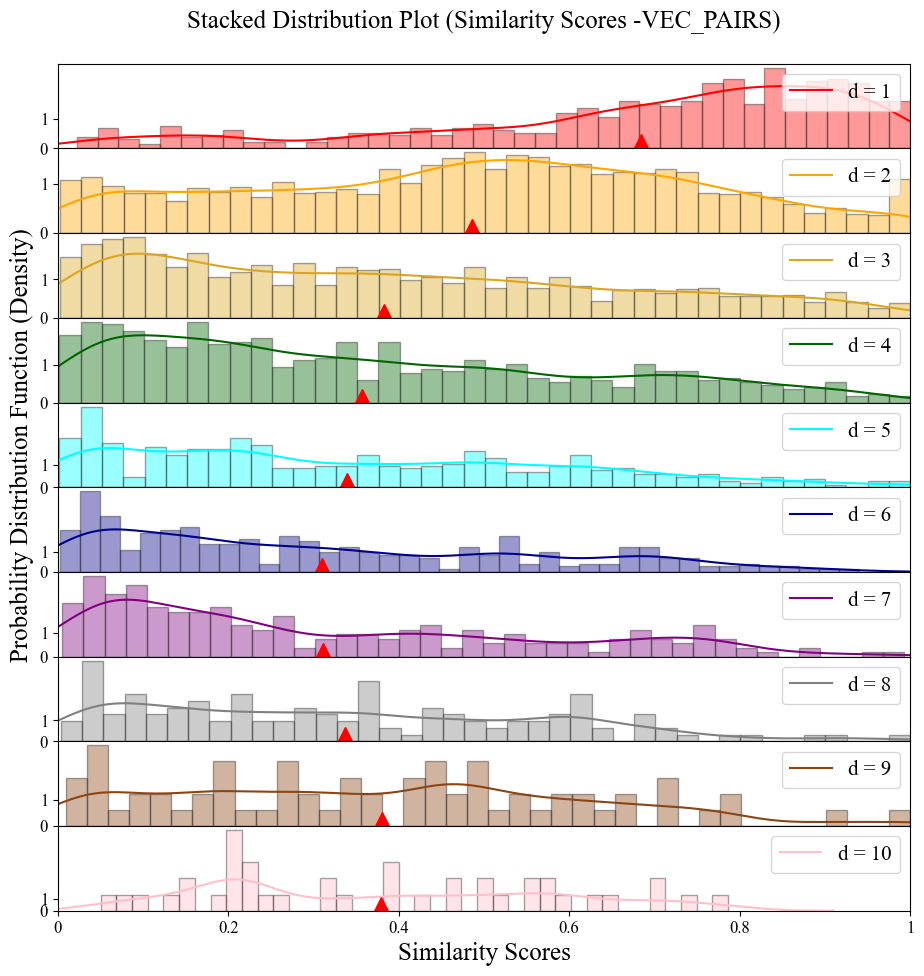

Compute spearman's R for Distances (Real Distances vs. Inferred Distances) 
and Similarities (Similarity Scores vs. Inferred Similarities). 
Similarity Metric:  vec_pairs
R_Similarity =  0.368
R_Distance =  0.222


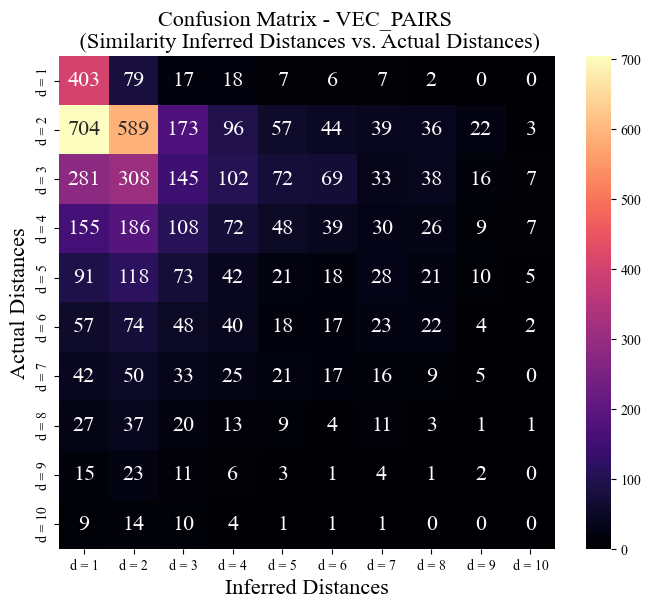


Classification Report

              precision    recall  f1-score   support

           1       0.23      0.75      0.35       539
           2       0.40      0.33      0.36      1763
           3       0.23      0.14      0.17      1071
           4       0.17      0.11      0.13       680
           5       0.08      0.05      0.06       427
           6       0.08      0.06      0.07       305
           7       0.08      0.07      0.08       218
           8       0.02      0.02      0.02       126
           9       0.03      0.03      0.03        66
          10       0.00      0.00      0.00        40

    accuracy                           0.24      5235
   macro avg       0.13      0.16      0.13      5235
weighted avg       0.24      0.24      0.22      5235



In [66]:
plot_stacked_distribution_similarity_scores(similarity_metric="vec_pairs", 
                                            plot_name="Similarity",
                                            smiles_list="smiles_test")

100%|██████████████████████████████████████████████████████████████████████████| 3986/3986 [00:00<00:00, 664223.11it/s]


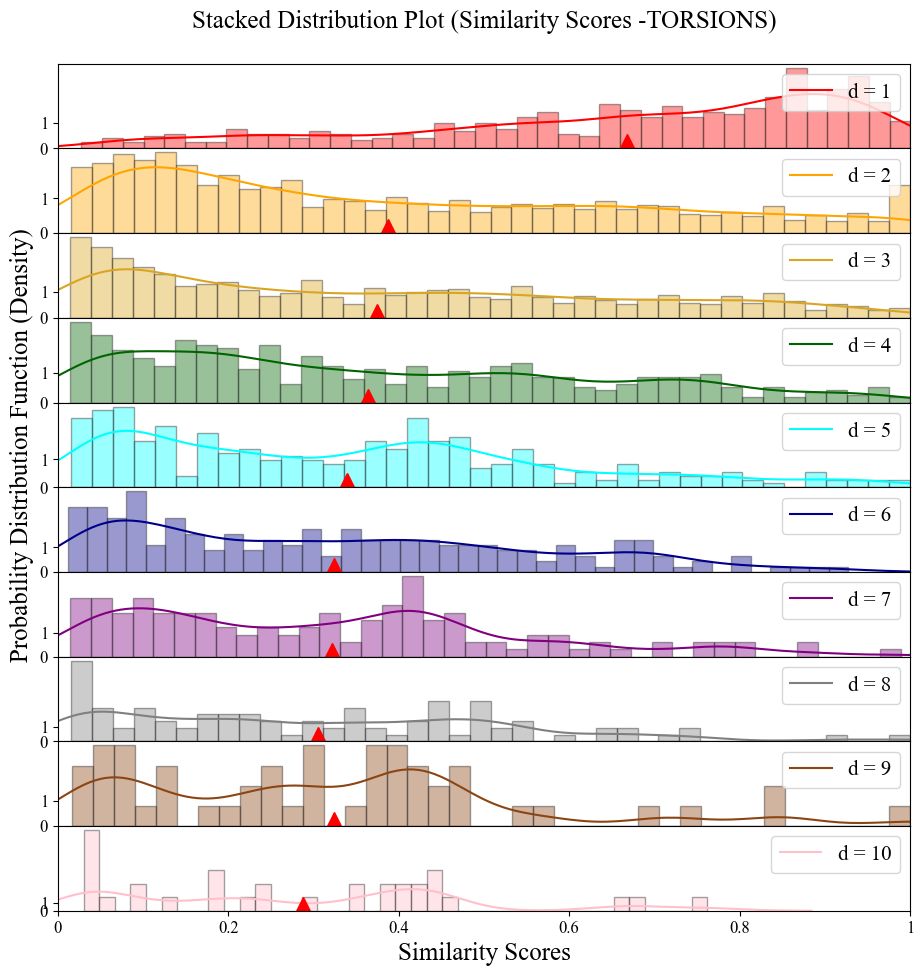

Compute spearman's R for Distances (Real Distances vs. Inferred Distances) 
and Similarities (Similarity Scores vs. Inferred Similarities). 
Similarity Metric:  torsions
R_Similarity =  0.308
R_Distance =  0.16


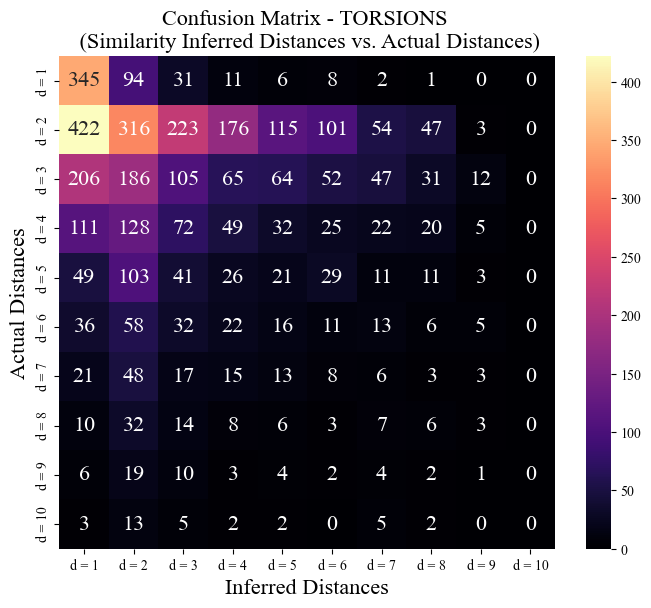


Classification Report

              precision    recall  f1-score   support

           1       0.29      0.69      0.40       498
           2       0.32      0.22      0.26      1457
           3       0.19      0.14      0.16       768
           4       0.13      0.11      0.12       464
           5       0.08      0.07      0.07       294
           6       0.05      0.06      0.05       199
           7       0.04      0.04      0.04       134
           8       0.05      0.07      0.06        89
           9       0.03      0.02      0.02        51
          10       0.00      0.00      0.00        32

    accuracy                           0.22      3986
   macro avg       0.12      0.14      0.12      3986
weighted avg       0.21      0.22      0.20      3986



In [67]:
plot_stacked_distribution_similarity_scores(similarity_metric="torsions", 
                                            plot_name="Similarity",
                                            smiles_list="smiles_test")